# GLM: Click Inputs to Decision Variables with sklearn ElasticNetCV

Build a GLM to predict decision variables DV(t) from click input data for the first 240 trials of session A324_2023-07-27, using Gaussian basis functions and ElasticNet regularization (L1 ratio = 0.95).

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# GLM libraries - using sklearn ElasticNetCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Set random seed for reproducibility
np.random.seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Built-in standardization enabled (no sklearn StandardScaler needed)")

Built-in standardization enabled (no sklearn StandardScaler needed)


## 1. Data Loading and Preparation

Load session data and filter to first 240 trials.

In [26]:
# Data paths configuration
PROJECT_ROOT = Path('/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV')
SESSION_ID = 'A324'
SESSION_DATE = '2023-07-27'  # Using the date from the plan

# Path to processed H5 file (this is what we'll actually use)
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed' / SESSION_ID / SESSION_DATE
H5_FILE = OUTPUT_DIR / f'{SESSION_ID}_{SESSION_DATE}_session_data.h5'

# Verify H5 file exists
if not H5_FILE.exists():
    raise FileNotFoundError(f"Processed H5 file not found: {H5_FILE}")

print(f"Project root: {PROJECT_ROOT}")
print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"H5 file: {H5_FILE}")
print(f"H5 file size: {H5_FILE.stat().st_size / 1024 / 1024:.1f} MB")

Project root: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV
Session: A324 (2023-07-27)
H5 file: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
H5 file size: 154.2 MB


In [27]:
def load_session_data(h5_file_path=None):
    """
    Load session data from H5 file and return DataFrames
    
    Args:
        h5_file_path: Path to H5 file (uses global H5_FILE if None)
    
    Returns:
        trial_df: Trial metadata
        click_df: Click events data  
        dv_df: Decision variables data
    """
    if h5_file_path is None:
        h5_file_path = H5_FILE
    
    if not h5_file_path.exists():
        raise FileNotFoundError(f"Data file not found: {h5_file_path}")
    
    print(f"Loading data from: {h5_file_path}")
    
    # Use pandas HDFStore to load the data
    with pd.HDFStore(h5_file_path, mode='r') as store:
        trial_df = store.get('trials')
        click_df = store.get('clicks')
        dv_df = store.get('decision_variables')
    
    print(f"Loaded {len(trial_df)} trials, {len(click_df)} clicks, {len(dv_df)} DV points")
    
    return trial_df, click_df, dv_df

In [28]:
# Load full session data
trial_df, click_df, dv_df = load_session_data()

min_session_trials = 900

# Filter to first 900 trials
trial_df_240 = trial_df[trial_df['trial_id'] < min_session_trials].copy()
click_df_240 = click_df[click_df['trial_id'] < min_session_trials].copy()
dv_df_240 = dv_df[dv_df['trial_id'] < min_session_trials].copy()

print(f"\nFiltered to first {min_session_trials} trials:")
print(f"Trials: {len(trial_df_240)}")
print(f"Clicks: {len(click_df_240)}")
print(f"DV points: {len(dv_df_240)}")
print(f"Valid DV points: {dv_df_240['is_valid'].sum()}")

Loading data from: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
Loaded 774 trials, 22144 clicks, 17028 DV points

Filtered to first 900 trials:
Trials: 774
Clicks: 22144
DV points: 17028
Valid DV points: 13860


In [29]:
# Data validation and exploration
print("Click distribution:")
print(click_df_240['click_side'].value_counts())

print("\nDV statistics:")
valid_dvs = dv_df_240[dv_df_240['is_valid']]
print(f"DV range: [{valid_dvs['decision_variable'].min():.3f}, {valid_dvs['decision_variable'].max():.3f}]")
print(f"DV mean: {valid_dvs['decision_variable'].mean():.3f}")
print(f"DV std: {valid_dvs['decision_variable'].std():.3f}")

print("\nTrial duration statistics:")
trial_durations = trial_df_240.groupby('trial_id')['trial_duration'].first()
print(f"Duration range: [{trial_durations.min():.2f}, {trial_durations.max():.2f}] seconds")
print(f"Mean duration: {trial_durations.mean():.2f} seconds")

Click distribution:
click_side
right    11741
left     10403
Name: count, dtype: int64

DV statistics:
DV range: [-31.808, 34.479]
DV mean: 0.420
DV std: 9.900

Trial duration statistics:
Duration range: [1.50, 18.67] seconds
Mean duration: 1.75 seconds


## 2. Design Gaussian Basis Functions

Create temporal kernels to capture click history at different timescales.

In [30]:
# Define basis function parameters - SIMPLIFIED: varying widths only
n_basis = 10  # Number of Gaussian basis functions
time_windows = [0] #[0, -0.02, -0.04]
width_min = 0.01  # Minimum width (10ms)
width_max = 0.5   # Maximum width (500ms)

# Log-spaced widths for basis functions (no centers needed!)
widths = np.logspace(np.log10(width_min), np.log10(width_max), n_basis)

# Calculate centers with half-width offset spacing
offset_to_width_ratio = 0.5
centers = np.zeros(n_basis)
centers[0] = widths[0] * offset_to_width_ratio  # First center at half its width
for i in range(1, n_basis):
    # Each center offset by half-width of previous and current
    centers[i] = centers[i-1] + offset_to_width_ratio * (widths[i-1] + widths[i])

# Add small random offsets to break regularity
centers = centers + np.random.uniform(-0.01, 0.01, n_basis)
# Scale centers to fit in reasonable range (up to 400ms)
# if centers[-1] > 0.4:
#     centers = centers * (0.4 / centers[-1])

print(f"Centers range from {centers[0]*1000:.1f}ms to {centers[-1]*1000:.1f}ms")
print(f"Widths range from {widths[0]*1000:.1f}ms to {widths[-1]*1000:.1f}ms")

print(f"Created {n_basis} basis functions")
print(f"Width range: {width_min*1000:.1f} - {width_max*1000:.1f} ms")
print(f"Widths (ms): {(widths*1000).round(1)}")

def gaussian_basis(t, center, width, causal=True):
    """
    Gaussian basis function centered at specified time
    
    Args:
        t: Time points (0 = click time)
        center: Center of Gaussian (time after click)
        width: Width (standard deviation) of Gaussian
        causal: If True, zero out negative times (before click)
    
    Returns:
        Normalized Gaussian values at times t
    """
    # Gaussian basis function centered at specified time
    # Gaussian centered at "center" ms after click
    gaussian = (1/(width * np.sqrt(2*np.pi))) * np.exp(-(t - center)**2 / (2 * width**2))

    # gaussian = np.exp(-(t - center)**2 / (2 * width**2))

    
    if causal:
        # Only keep t>=0 (after click)
        gaussian = np.where(t >= 0, gaussian, 0)
    
    return gaussian

Centers range from 2.5ms to 1154.1ms
Widths range from 10.0ms to 500.0ms
Created 10 basis functions
Width range: 10.0 - 500.0 ms
Widths (ms): [ 10.   15.4  23.9  36.8  56.9  87.9 135.7 209.6 323.7 500. ]


## 3. Feature Engineering: Convolve Clicks with Basis Functions

For each DV time point, create feature vectors by convolving click history with Gaussian basis functions.

In [31]:
def create_click_kernel(dt=0.001):
    """
    Create a kernel matching the actual click shape:
    3ms cosine envelope as used in the behavioral experiment.
    
    Args:
        dt: Time step in seconds (default 1ms = 0.001s)
    
    Returns:
        envelope: Normalized cosine envelope array
    """
    # 3ms total width matching actual click duration
    click_duration = 0.003  # 3ms
    n_samples = int(np.ceil(click_duration / dt))
    t = np.linspace(0, click_duration, n_samples)
    
    # Raised cosine (Hann window) - matches the cosine envelope used in experiment
    envelope = 0.5 * (1 - np.cos(2 * np.pi * t / click_duration))
    
    # Normalize to preserve total energy (sum = 1)
    envelope = envelope / envelope.sum()
    
    return envelope

def create_trial_features(trial_clicks_left, trial_clicks_right, dv_eval_times, centers, widths, 
                         trial_duration, store_convolutions=False, time_windows=[0]):
    """
    Create feature matrix with multiple temporal windows for richer representation.
    
    This approach:
    1. Creates fine temporal bins at 1ms resolution for entire trial duration  
    2. Places 3ms cosine-shaped clicks (matching actual acoustic stimuli) at click times
    3. Convolves with causal Gaussian basis functions (centered at different offsets, varying widths)
    4. Evaluates at multiple time windows relative to each DV time point
    5. Concatenates features from all windows for richer representation
    
    Args:
        trial_clicks_left: Array of left click times for this trial
        trial_clicks_right: Array of right click times for this trial  
        dv_eval_times: Array of DV evaluation times for this trial
        centers: Basis function centers (temporal offsets in seconds)
        widths: Basis function widths (standard deviations in seconds)
        trial_duration: Duration of trial in seconds
        store_convolutions: If True, return full convolution outputs for visualization
        time_windows: List of time offsets (in seconds) relative to DV evaluation times
                     Default: [0, -0.02, -0.04] for current, 20ms before, and 40ms before
    
    Returns:
        If store_convolutions=False:
            features_matrix: (n_dv_times, n_features) array where 
                           n_features = 2 * n_basis * n_windows
        If store_convolutions=True:
            features_matrix, stored_convolutions dict
    """
    # Fine temporal binning parameters - now 1ms for proper click representation
    dt = 0.001  # 1ms resolution to capture 3ms clicks properly
    
    # Create click kernel for 3ms cosine envelope
    click_kernel = create_click_kernel(dt)
    
    # Create temporal grid for entire trial - extend to handle edge effects
    # Add padding at the end for proper convolution
    max_kernel_extent = 6 * widths.max()  # Maximum kernel extent
    padded_duration = trial_duration + max_kernel_extent
    time_grid = np.arange(0, padded_duration + dt, dt)
    n_bins = len(time_grid)
    
    # Initialize smooth click signals (not impulses)
    clicks_left = np.zeros(n_bins)
    clicks_right = np.zeros(n_bins)
    
    # Place cosine-shaped clicks (not delta functions) across entire trial
    for click_time in trial_clicks_left:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            # Place the 3ms cosine envelope centered at click time
            for i, amplitude in enumerate(click_kernel):
                if 0 <= bin_idx + i < n_bins:
                    clicks_left[bin_idx + i] += amplitude
    
    for click_time in trial_clicks_right:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            # Place the 3ms cosine envelope centered at click time
            for i, amplitude in enumerate(click_kernel):
                if 0 <= bin_idx + i < n_bins:
                    clicks_right[bin_idx + i] += amplitude
    
    # Initialize convolved signals storage
    n_dv_times = len(dv_eval_times)
    n_basis = len(widths)
    n_windows = len(time_windows)
    # Features: left/right × basis functions × time windows
    features_matrix = np.zeros((n_dv_times, 2 * n_basis * n_windows))
    
    if store_convolutions:
        # Only store the unpadded portion for visualization
        actual_trial_bins = int(np.ceil(trial_duration / dt))
        stored_convolutions = {
            'left': [],
            'right': [],
            'time_grid': time_grid[:actual_trial_bins],
            'clicks_left': clicks_left[:actual_trial_bins],
            'clicks_right': clicks_right[:actual_trial_bins],
            'dt': dt,
            'time_windows': time_windows
        }
    
    # Convolve once per basis function
    convolved_left = []
    convolved_right = []
    
    for i, width in enumerate(widths):
        # Create causal Gaussian kernel centered at specified offset
        max_lag = min(6 * widths[i], padded_duration)
        kernel_n_bins = int(np.ceil(max_lag / dt)) + 1
        
        # Time since click: 0 = click time, dt = one bin after, etc.
        time_lags = np.arange(0, kernel_n_bins * dt, dt)
        
        # Create Gaussian centered at specified offset (peak at center[i] after click)
        causal_kernel = gaussian_basis(time_lags, centers[i], widths[i], causal=True)
        
        # Convolve clicks with causal kernel
        conv_left_full = np.convolve(clicks_left, causal_kernel, mode='full')
        conv_right_full = np.convolve(clicks_right, causal_kernel, mode='full')
        
        # Trim to match original grid size
        conv_left = conv_left_full[:n_bins]
        conv_right = conv_right_full[:n_bins]
        
        convolved_left.append(conv_left)
        convolved_right.append(conv_right)
        
        if store_convolutions:
            actual_trial_bins = len(stored_convolutions['time_grid'])
            stored_convolutions['left'].append(conv_left[:actual_trial_bins])
            stored_convolutions['right'].append(conv_right[:actual_trial_bins])
    
    # Sample at multiple time windows for each DV evaluation time
    for j, eval_time in enumerate(dv_eval_times):
        feature_idx = 0
        
        for w, window_offset in enumerate(time_windows):
            # Compute the sampling time for this window
            sample_time = eval_time + window_offset
            
            # Skip if sample time is negative (before trial start)
            if sample_time < 0:
                # Fill with zeros for this window
                feature_idx += 2 * n_basis
                continue
            
            # Find the time bin for this window
            sample_bin = int(np.floor(sample_time / dt))
            
            if 0 <= sample_bin < n_bins:
                # Extract features for all basis functions at this time window
                for i in range(n_basis):
                    # Left feature
                    features_matrix[j, feature_idx] = convolved_left[i][sample_bin]
                    feature_idx += 1
                    # Right feature  
                    features_matrix[j, feature_idx] = convolved_right[i][sample_bin]
                    feature_idx += 1
            else:
                # Fill with zeros if outside valid range
                feature_idx += 2 * n_basis
    
    if store_convolutions:
        return features_matrix, stored_convolutions
    else:
        return features_matrix

# Test the multi-window implementation
test_trial = 5
trial_clicks = click_df_240[click_df_240['trial_id'] == test_trial]
left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values

# Get the actual trial data for proper processing
trial_dvs = dv_df_240[dv_df_240['trial_id'] == test_trial]

# Get trial duration from DV data (max time_bin)
if len(trial_dvs) > 0:
    trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
else:
    trial_duration = 2.0

print(f"Test trial {test_trial} (Multi-window approach with 3ms cosine clicks):")
print(f"Left clicks: {len(left_clicks)}")
print(f"Right clicks: {len(right_clicks)}")
print(f"Trial duration: {trial_duration:.3f}s")

# Test with storing convolutions for visualization
if len(trial_dvs) > 0:
    dv_times = trial_dvs['time_bin'].values
    
    # Test with multiple windows: current, 20ms before, 40ms before
    features_matrix, stored_convs = create_trial_features(
        left_clicks, right_clicks, dv_times, centers, widths, trial_duration, 
        store_convolutions=True, time_windows=time_windows
    )
    
    print(f"\nFeatures matrix shape: {features_matrix.shape}")
    print(f"Expected shape: ({len(dv_times)}, {2 * n_basis * len(time_windows)})")
    print(f"Features per window: {2 * n_basis}")
    print(f"Number of windows: {len(time_windows)}")
    print(f"Time windows: {[w*1000 for w in time_windows]}ms relative to DV")
    print(f"Features range: [{features_matrix.min():.4f}, {features_matrix.max():.4f}]")
    print("✓ Multi-window feature extraction implemented!")

Test trial 5 (Multi-window approach with 3ms cosine clicks):
Left clicks: 5
Right clicks: 8
Trial duration: 1.075s

Features matrix shape: (22, 20)
Expected shape: (22, 20)
Features per window: 20
Number of windows: 1
Time windows: [0]ms relative to DV
Features range: [0.0000, 77.1411]
✓ Multi-window feature extraction implemented!


In [32]:
class MultiWindowFeatureHelper:
    """
    Helper class for managing multi-window feature organization in GLM.
    
    Features are organized as alternating left/right within each window:
    [window1[L1,R1,L2,R2,...], window2[L1,R1,L2,R2,...], ...]
    
    This class provides methods to extract features by side, window, or basis,
    making it easy to work with any configuration of n_basis and time_windows.
    """
    
    def __init__(self, n_basis, time_windows):
        """
        Initialize helper with GLM configuration.
        
        Args:
            n_basis: Number of basis functions
            time_windows: List of time offsets (e.g., [0, -0.02, -0.04])
        """
        self.n_basis = n_basis
        self.n_windows = len(time_windows)
        self.time_windows = time_windows
        self.features_per_window = 2 * n_basis  # L/R alternating
        self.total_features = self.features_per_window * self.n_windows
    
    def get_feature_indices(self, window_idx=None, side=None, basis_idx=None):
        """
        Get feature indices for specific combinations.
        
        Args:
            window_idx: Window index (0, 1, 2, ...) or None for all
            side: 'left', 'right', or None for both
            basis_idx: Basis function index (0 to n_basis-1) or None for all
            
        Returns:
            List of feature indices
        """
        indices = []
        
        # Determine which windows to include
        if window_idx is not None:
            windows = [window_idx]
        else:
            windows = range(self.n_windows)
        
        # Determine which basis functions to include
        if basis_idx is not None:
            bases = [basis_idx]
        else:
            bases = range(self.n_basis)
        
        # Build indices
        for w in windows:
            window_start = w * self.features_per_window
            for b in bases:
                if side == 'left' or side is None:
                    indices.append(window_start + 2 * b)  # Left is even indices
                if side == 'right' or side is None:
                    indices.append(window_start + 2 * b + 1)  # Right is odd indices
        
        return sorted(indices)
    
    def extract_features_by_side(self, X):
        """
        Extract all left and right features from multi-window matrix.
        
        Args:
            X: Feature matrix of shape (n_samples, total_features)
            
        Returns:
            left_features: All left features from all windows (n_samples, n_basis * n_windows)
            right_features: All right features from all windows (n_samples, n_basis * n_windows)
        """
        left_indices = self.get_feature_indices(side='left')
        right_indices = self.get_feature_indices(side='right')
        
        left_features = X[:, left_indices]
        right_features = X[:, right_indices]
        
        return left_features, right_features
    
    def extract_features_by_window(self, X):
        """
        Extract features organized by window.
        
        Args:
            X: Feature matrix of shape (n_samples, total_features)
            
        Returns:
            List of feature matrices, one per window
        """
        window_features = []
        for w in range(self.n_windows):
            start_idx = w * self.features_per_window
            end_idx = start_idx + self.features_per_window
            window_features.append(X[:, start_idx:end_idx])
        return window_features
    
    def extract_coefficients_by_side(self, coefs):
        """
        Extract left/right coefficients from multi-window coefficient vector.
        
        Args:
            coefs: Coefficient vector of length total_features
            
        Returns:
            left_coefs: Matrix of shape (n_windows, n_basis)
            right_coefs: Matrix of shape (n_windows, n_basis)
        """
        left_coefs = np.zeros((self.n_windows, self.n_basis))
        right_coefs = np.zeros((self.n_windows, self.n_basis))
        
        for w in range(self.n_windows):
            for b in range(self.n_basis):
                left_idx = self.get_feature_indices(window_idx=w, side='left', basis_idx=b)[0]
                right_idx = self.get_feature_indices(window_idx=w, side='right', basis_idx=b)[0]
                left_coefs[w, b] = coefs[left_idx]
                right_coefs[w, b] = coefs[right_idx]
        
        return left_coefs, right_coefs
    
    def get_feature_labels(self, short=False):
        """
        Generate descriptive labels for all features.
        
        Args:
            short: If True, use abbreviated labels
            
        Returns:
            List of labels for each feature
        """
        labels = []
        for w in range(self.n_windows):
            window_ms = int(self.time_windows[w] * 1000) if w < len(self.time_windows) else 0
            for b in range(self.n_basis):
                if short:
                    # Short format: L1w0, R1w0, L2w-20, etc.
                    labels.append(f"L{b+1}w{window_ms}")
                    labels.append(f"R{b+1}w{window_ms}")
                else:
                    # Long format: Left B1 @0ms, Right B1 @0ms, etc.
                    labels.append(f"Left B{b+1} @{window_ms}ms")
                    labels.append(f"Right B{b+1} @{window_ms}ms")
        return labels
    
    def reconstruct_response_functions(self, coefs, centers, widths, t):
        """
        Build temporal response functions from multi-window coefficients.
        
        This properly sums contributions from all time windows, accounting for
        the fact that each window samples at a different offset relative to the
        DV evaluation time.
        
        Args:
            coefs: Coefficient vector of length total_features
            centers: Basis function centers
            widths: Basis function widths
            t: Time points for evaluation
            
        Returns:
            left_response: Combined left click response function
            right_response: Combined right click response function
        """
        # Extract coefficients by side and window
        left_coef_matrix, right_coef_matrix = self.extract_coefficients_by_side(coefs)
        
        # Initialize response functions
        left_response = np.zeros_like(t)
        right_response = np.zeros_like(t)
        
        # Sum contributions from all windows
        for w in range(self.n_windows):
            # Each window has a different temporal offset
            window_offset = self.time_windows[w]
            
            # Build response for this window
            for b in range(self.n_basis):
                if left_coef_matrix[w, b] != 0:
                    # Shift the basis function by the window offset
                    # Window offset is negative (looking back in time)
                    # So we shift the basis function forward in time
                    shifted_t = t - window_offset
                    basis = gaussian_basis(shifted_t, centers[b], widths[b], causal=True)
                    left_response += left_coef_matrix[w, b] * basis
                    
                if right_coef_matrix[w, b] != 0:
                    shifted_t = t - window_offset
                    basis = gaussian_basis(shifted_t, centers[b], widths[b], causal=True)
                    right_response += right_coef_matrix[w, b] * basis
        
        return left_response, right_response

# Initialize helper with current configuration
helper = MultiWindowFeatureHelper(n_basis, time_windows)
print(f"✓ MultiWindowFeatureHelper initialized")
print(f"  n_basis: {helper.n_basis}")
print(f"  n_windows: {helper.n_windows}")
print(f"  time_windows: {[w*1000 for w in helper.time_windows]}ms")
print(f"  total_features: {helper.total_features}")

✓ MultiWindowFeatureHelper initialized
  n_basis: 10
  n_windows: 1
  time_windows: [0]ms
  total_features: 20


In [33]:
# Build feature matrix X and target vector y for all trials
print("Building feature matrix with multi-window approach...")

X = []
y = []
valid_mask = []
trial_ids = []
time_bins = []

# Progress tracking
from tqdm import tqdm

# Only process first 240 trials as specified
n_trials_to_process = min(240, dv_df_240['trial_id'].max() + 1)

for trial_id in tqdm(range(n_trials_to_process), desc="Processing trials"):
    # Get clicks for this trial - use time_from_first_click to match test above
    trial_clicks = click_df_240[click_df_240['trial_id'] == trial_id]
    left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
    right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values
    
    # Get DVs for this trial
    trial_dvs = dv_df_240[dv_df_240['trial_id'] == trial_id]
    
    if len(trial_dvs) > 0:
        # Extract DV evaluation times 
        dv_eval_times = trial_dvs['time_bin'].values
        
        # Get trial duration from DV data (max time_bin represents time_from_first_click)
        # Add small buffer to ensure we capture the full trial
        trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
        
        # Use multi-window feature creation
        try:
            features_matrix = create_trial_features(
                left_clicks, right_clicks, dv_eval_times, centers, widths, 
                trial_duration, store_convolutions=False, time_windows=time_windows
            )
            
            # Add features and targets for all DV time points in this trial
            for i, (_, dv_row) in enumerate(trial_dvs.iterrows()):
                X.append(features_matrix[i])
                y.append(dv_row['decision_variable'])
                valid_mask.append(dv_row['is_valid'])
                trial_ids.append(trial_id)
                time_bins.append(dv_row['time_bin'])
                
        except Exception as e:
            print(f"Warning: Error processing trial {trial_id}: {e}")
            # Skip this trial if there's an error
            continue

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
valid_mask = np.array(valid_mask)
trial_ids = np.array(trial_ids)
time_bins = np.array(time_bins)

print(f"Feature matrix constructed with multi-window approach:")
print(f"Total observations: {len(X)}")
print(f"Features per observation: {X.shape[1]} ({helper.n_windows} windows × {n_basis} basis × 2 sides)")
print(f"Valid observations: {valid_mask.sum()}")
print(f"Invalid observations: {(~valid_mask).sum()}")

# Keep only valid DV points
X_valid = X[valid_mask]
y_valid = y[valid_mask]
trial_ids_valid = trial_ids[valid_mask]
time_bins_valid = time_bins[valid_mask]

print(f"Final dataset for GLM:")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"Data covers {len(np.unique(trial_ids_valid))} unique trials")


Building feature matrix with multi-window approach...


Processing trials: 100%|██████████| 240/240 [00:01<00:00, 121.79it/s]

Feature matrix constructed with multi-window approach:
Total observations: 5280
Features per observation: 20 (1 windows × 10 basis × 2 sides)
Valid observations: 4266
Invalid observations: 1014
Final dataset for GLM:
X_valid shape: (4266, 20)
y_valid shape: (4266,)
Data covers 240 unique trials


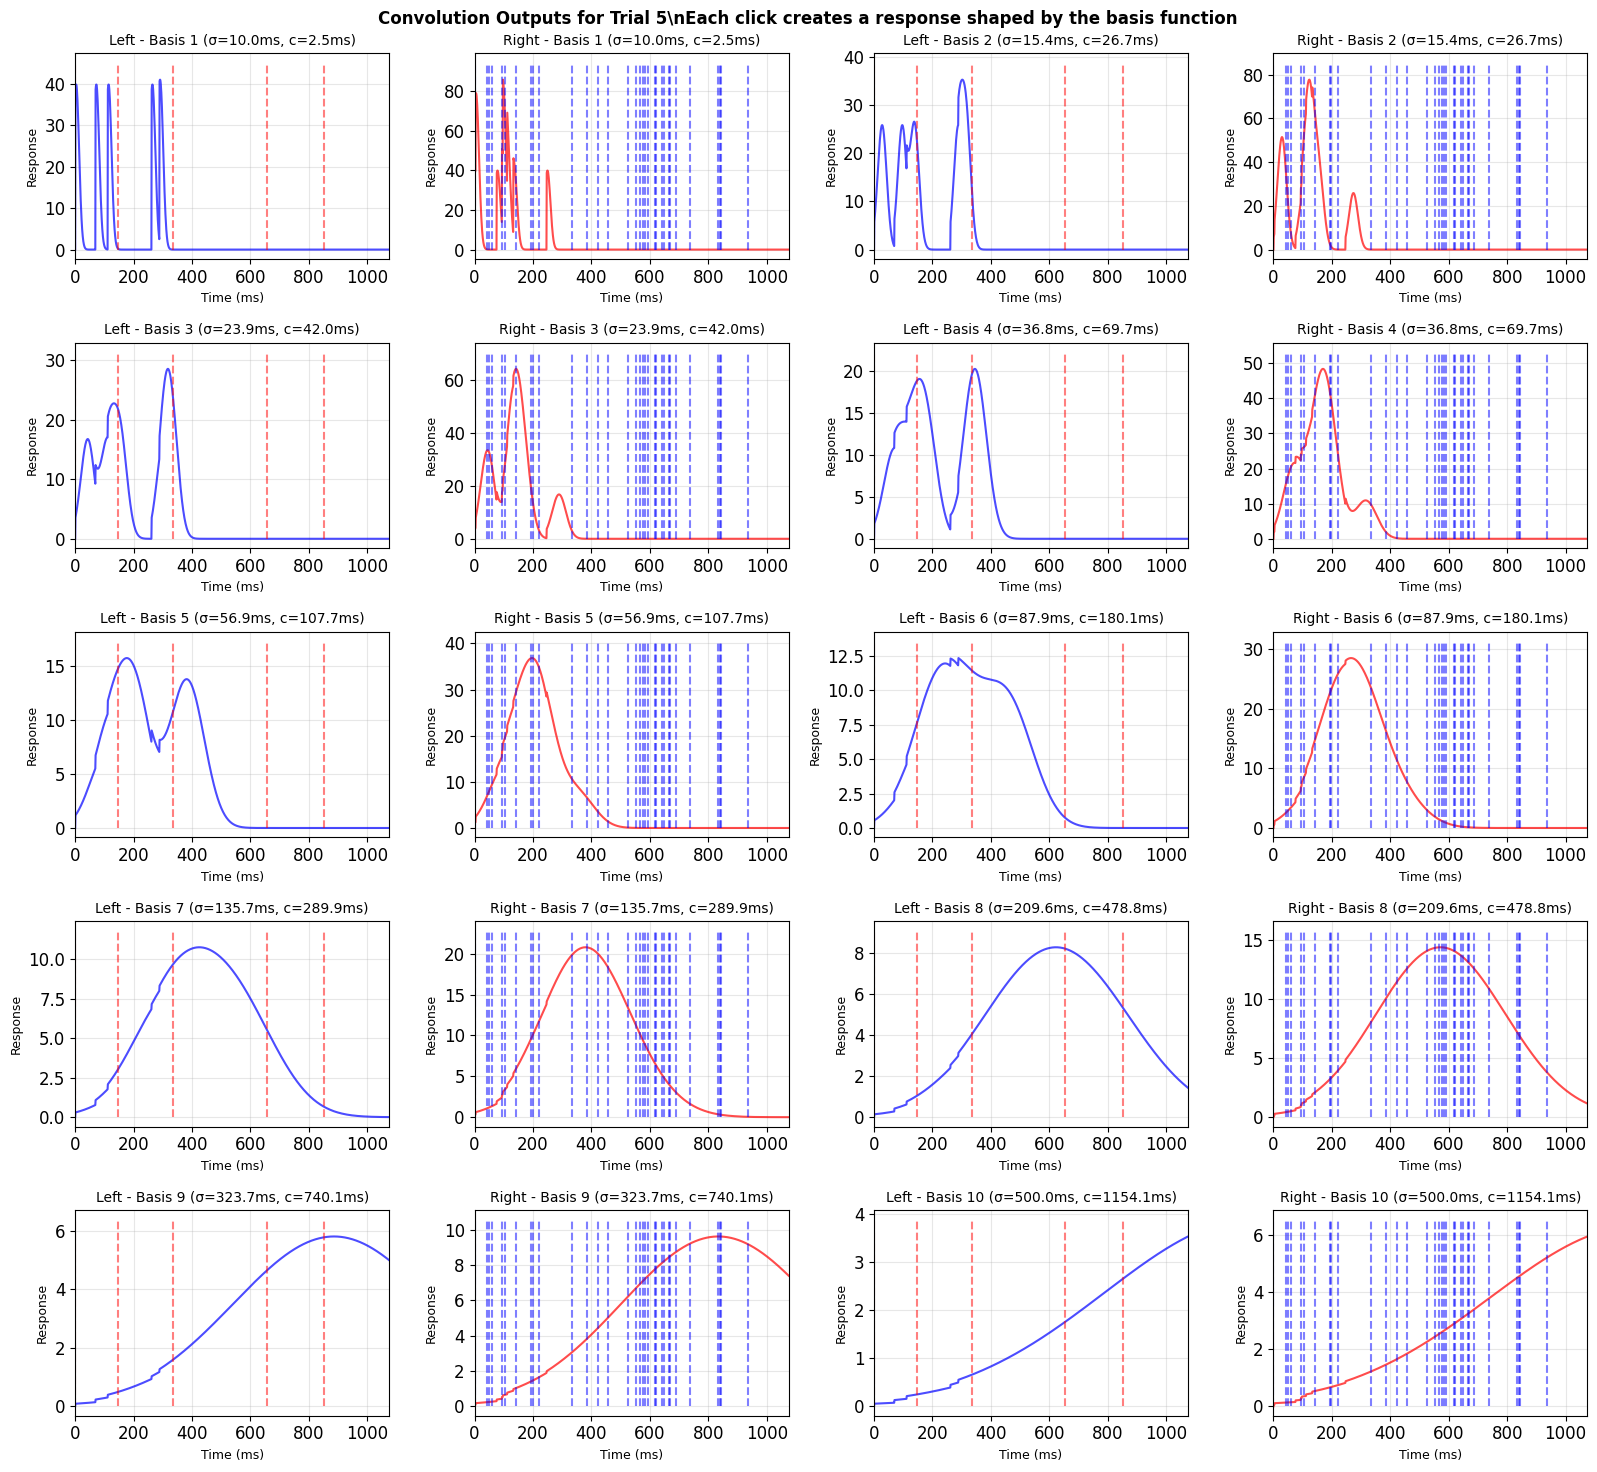

\n=== RESPONSE PATTERN ANALYSIS ===
\nBasis 1 (σ=10.0ms, center=2.5ms):
  Left clicks: 5, Peaks found: 5
  Right clicks: 32, Peaks found: 7
  Left monotonically decreasing: False (Good - multiple peaks!)
  Right monotonically decreasing: False (Good - multiple peaks!)
\nBasis 2 (σ=15.4ms, center=26.7ms):
  Left clicks: 5, Peaks found: 5
  Right clicks: 32, Peaks found: 4
  Left monotonically decreasing: False (Good - multiple peaks!)
  Right monotonically decreasing: False (Good - multiple peaks!)
\nBasis 3 (σ=23.9ms, center=42.0ms):
  Left clicks: 5, Peaks found: 4
  Right clicks: 32, Peaks found: 4
  Left monotonically decreasing: False (Good - multiple peaks!)
  Right monotonically decreasing: False (Good - multiple peaks!)
\n✓ Convolution visualization complete!
Note: With 3ms cosine clicks and offset centers, responses show complex temporal patterns.


In [34]:
# Visualize convolutions to verify non-monotonic behavior (should show bumps at each click)
if len(stored_convs) > 0:
    fig, axes = plt.subplots(5, 4, figsize=(16, 15))
    axes = axes.flatten()
    
    # Get time grid (same for all basis functions)
    time_ms = stored_convs['time_grid'] * 1000  # Convert to milliseconds
    
    for i in range(min(n_basis, 10)):
        # Left convolutions
        ax_left = axes[i * 2]
        # Make sure we only plot up to the length of the convolution
        conv_left = stored_convs['left'][i][:len(time_ms)]
        ax_left.plot(time_ms[:len(conv_left)], conv_left, 'b-', alpha=0.7, linewidth=1.5)
        
        # Mark clicks with vertical lines
        if len(conv_left) > 0 and max(conv_left) > 0:
            ax_left.vlines(left_clicks * 1000, 0, max(conv_left) * 1.1, 
                          colors='red', alpha=0.5, linestyles='dashed', label='Clicks')
        
        ax_left.set_title(f'Left - Basis {i+1} (σ={widths[i]*1000:.1f}ms, c={centers[i]*1000:.1f}ms)', fontsize=10)
        ax_left.set_xlabel('Time (ms)', fontsize=9)
        ax_left.set_ylabel('Response', fontsize=9)
        ax_left.grid(True, alpha=0.3)
        ax_left.set_xlim([0, min(trial_duration * 1000, len(time_ms))])
        
        # Right convolutions  
        ax_right = axes[i * 2 + 1]
        conv_right = stored_convs['right'][i][:len(time_ms)]
        ax_right.plot(time_ms[:len(conv_right)], conv_right, 'r-', alpha=0.7, linewidth=1.5)
        
        # Mark clicks with vertical lines
        if len(conv_right) > 0 and max(conv_right) > 0:
            ax_right.vlines(right_clicks * 1000, 0, max(conv_right) * 1.1,
                           colors='blue', alpha=0.5, linestyles='dashed', label='Clicks')
        
        ax_right.set_title(f'Right - Basis {i+1} (σ={widths[i]*1000:.1f}ms, c={centers[i]*1000:.1f}ms)', fontsize=10)
        ax_right.set_xlabel('Time (ms)', fontsize=9)
        ax_right.set_ylabel('Response', fontsize=9)
        ax_right.grid(True, alpha=0.3)
        ax_right.set_xlim([0, min(trial_duration * 1000, len(time_ms))])
    
    plt.suptitle(f'Convolution Outputs for Trial {test_trial}\\nEach click creates a response shaped by the basis function', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Check for monotonic decrease
    print("\\n=== RESPONSE PATTERN ANALYSIS ===")
    for i in range(min(3, n_basis)):  # Check first 3 widths
        conv_left_i = stored_convs['left'][i]
        conv_right_i = stored_convs['right'][i]
        
        # Find peaks in convolution (should correspond to clicks)
        from scipy.signal import find_peaks
        
        # Use appropriate height threshold
        left_height = max(conv_left_i) * 0.1 if len(conv_left_i) > 0 and max(conv_left_i) > 0 else 0
        right_height = max(conv_right_i) * 0.1 if len(conv_right_i) > 0 and max(conv_right_i) > 0 else 0
        
        peaks_left, _ = find_peaks(conv_left_i, height=left_height) if left_height > 0 else ([], {})
        peaks_right, _ = find_peaks(conv_right_i, height=right_height) if right_height > 0 else ([], {})
        
        print(f"\\nBasis {i+1} (σ={widths[i]*1000:.1f}ms, center={centers[i]*1000:.1f}ms):")
        print(f"  Left clicks: {len(left_clicks)}, Peaks found: {len(peaks_left)}")
        print(f"  Right clicks: {len(right_clicks)}, Peaks found: {len(peaks_right)}")
        
        # Check if monotonically decreasing (shouldn't be with multiple clicks)
        is_monotonic_left = all(conv_left_i[j] >= conv_left_i[j+1] for j in range(len(conv_left_i)-1))
        is_monotonic_right = all(conv_right_i[j] >= conv_right_i[j+1] for j in range(len(conv_right_i)-1))
        
        print(f"  Left monotonically decreasing: {is_monotonic_left} {'(Good - multiple peaks!)' if not is_monotonic_left else '(May indicate single dominant click)'}")
        print(f"  Right monotonically decreasing: {is_monotonic_right} {'(Good - multiple peaks!)' if not is_monotonic_right else '(May indicate single dominant click)'}")
    
    print("\\n✓ Convolution visualization complete!")
    print("Note: With 3ms cosine clicks and offset centers, responses show complex temporal patterns.")

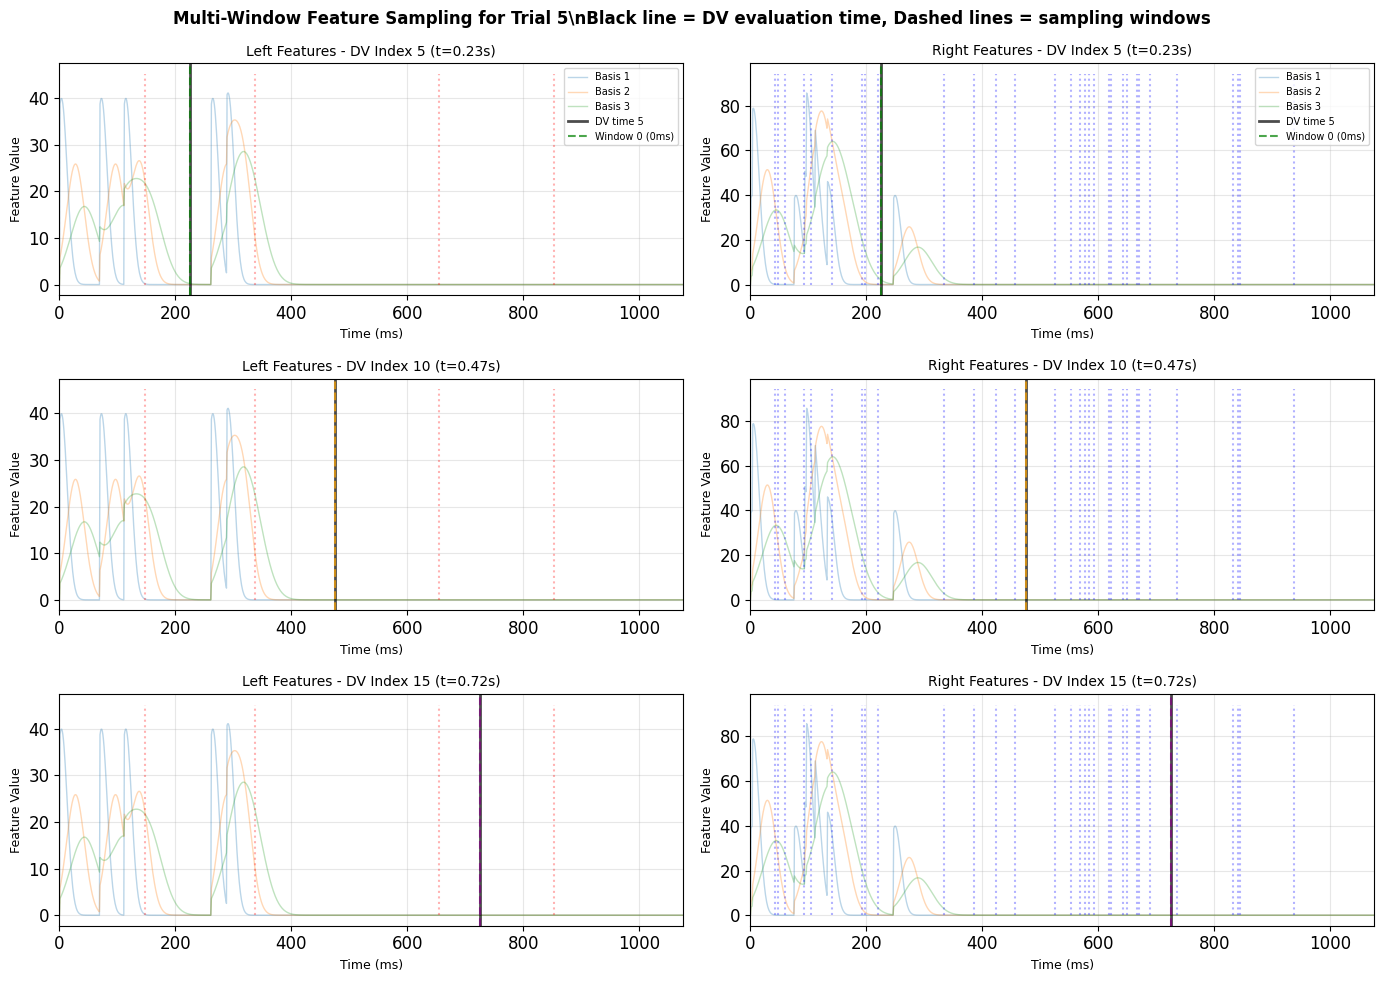


=== MULTI-WINDOW SAMPLING EXPLANATION ===
For each DV evaluation time, we sample features at multiple time offsets:
  • Window 0 (0ms): Sample at the exact DV time
  • Window 1 (-20ms): Sample 20ms before the DV time
  • Window 2 (-40ms): Sample 40ms before the DV time

This creates 20 features total:
  1 windows × 10 basis functions × 2 sides (L/R) = 20

✓ Multi-window approach captures temporal dynamics at different lags!


In [35]:
# Visualize multi-window feature sampling for the test trial
if len(stored_convs) > 0 and len(trial_dvs) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    
    # Show how features are sampled at different windows for a few DV evaluation times
    sample_dv_indices = [5, 10, 15] if len(dv_times) > 15 else range(min(3, len(dv_times)))
    colors = ['green', 'orange', 'purple']
    
    for row, (dv_idx, color) in enumerate(zip(sample_dv_indices, colors)):
        if dv_idx >= len(dv_times):
            continue
            
        dv_time = dv_times[dv_idx]
        
        # Left panel - show left click convolutions with sampling points
        ax_left = axes[row, 0]
        
        # Plot all convolved signals for left clicks
        time_grid = stored_convs['time_grid'] * 1000  # Convert to ms
        for b in range(min(3, n_basis)):  # Show first 3 basis functions
            ax_left.plot(time_grid, stored_convs['left'][b], 
                        alpha=0.3, linewidth=1, label=f'Basis {b+1}')
        
        # Mark the DV evaluation time
        ax_left.axvline(dv_time * 1000, color='black', linestyle='-', 
                       linewidth=2, alpha=0.7, label=f'DV time {dv_idx}')
        
        # Mark the sampling windows
        for w, window_offset in enumerate(time_windows):
            sample_time = (dv_time + window_offset) * 1000
            if sample_time >= 0:
                ax_left.axvline(sample_time, color=color, linestyle='--', 
                               alpha=0.7, label=f'Window {w} ({int(window_offset*1000)}ms)')
        
        # Add click markers
        ax_left.vlines(left_clicks * 1000, 0, 
                       max([max(stored_convs['left'][b]) for b in range(min(3, n_basis))]) * 1.1,
                       colors='red', alpha=0.3, linestyles='dotted')
        
        ax_left.set_title(f'Left Features - DV Index {dv_idx} (t={dv_time:.2f}s)', fontsize=10)
        ax_left.set_xlabel('Time (ms)', fontsize=9)
        ax_left.set_ylabel('Feature Value', fontsize=9)
        ax_left.grid(True, alpha=0.3)
        ax_left.set_xlim([0, trial_duration * 1000])
        if row == 0:
            ax_left.legend(fontsize=7, loc='upper right')
        
        # Right panel - show right click convolutions with sampling points
        ax_right = axes[row, 1]
        
        # Plot convolved signals for right clicks
        for b in range(min(3, n_basis)):
            ax_right.plot(time_grid, stored_convs['right'][b], 
                         alpha=0.3, linewidth=1, label=f'Basis {b+1}')
        
        # Mark the DV evaluation time
        ax_right.axvline(dv_time * 1000, color='black', linestyle='-', 
                        linewidth=2, alpha=0.7, label=f'DV time {dv_idx}')
        
        # Mark the sampling windows
        for w, window_offset in enumerate(time_windows):
            sample_time = (dv_time + window_offset) * 1000
            if sample_time >= 0:
                ax_right.axvline(sample_time, color=color, linestyle='--', 
                                alpha=0.7, label=f'Window {w} ({int(window_offset*1000)}ms)')
        
        # Add click markers
        ax_right.vlines(right_clicks * 1000, 0,
                        max([max(stored_convs['right'][b]) for b in range(min(3, n_basis))]) * 1.1,
                        colors='blue', alpha=0.3, linestyles='dotted')
        
        ax_right.set_title(f'Right Features - DV Index {dv_idx} (t={dv_time:.2f}s)', fontsize=10)
        ax_right.set_xlabel('Time (ms)', fontsize=9)
        ax_right.set_ylabel('Feature Value', fontsize=9)
        ax_right.grid(True, alpha=0.3)
        ax_right.set_xlim([0, trial_duration * 1000])
        if row == 0:
            ax_right.legend(fontsize=7, loc='upper right')
    
    plt.suptitle(f'Multi-Window Feature Sampling for Trial {test_trial}\\n' + 
                 f'Black line = DV evaluation time, Dashed lines = sampling windows', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n=== MULTI-WINDOW SAMPLING EXPLANATION ===")
    print(f"For each DV evaluation time, we sample features at multiple time offsets:")
    print(f"  • Window 0 (0ms): Sample at the exact DV time")
    print(f"  • Window 1 (-20ms): Sample 20ms before the DV time")  
    print(f"  • Window 2 (-40ms): Sample 40ms before the DV time")
    print(f"\nThis creates {helper.total_features} features total:")
    print(f"  {helper.n_windows} windows × {n_basis} basis functions × 2 sides (L/R) = {helper.total_features}")
    print("\n✓ Multi-window approach captures temporal dynamics at different lags!")

## 4. Build Design Matrix for GLM

Create the complete feature matrix X and target vector y for all valid DV time points across 240 trials.

In [36]:
# Feature matrix validation and summary statistics
print("=== FEATURE MATRIX ANALYSIS (MULTI-WINDOW) ===\n")

# Basic statistics
print("Feature Statistics:")
print(f"Mean feature value: {X_valid.mean():.6f}")
print(f"Std feature value: {X_valid.std():.6f}")
print(f"Min feature value: {X_valid.min():.6f}")
print(f"Max feature value: {X_valid.max():.6f}")

# Sparsity analysis
zero_features = (X_valid == 0).sum()
total_features = X_valid.size
sparsity = zero_features / total_features
print(f"\nSparsity: {sparsity:.3f} ({zero_features}/{total_features} zeros)")

# Use helper to correctly extract left/right features
left_features, right_features = helper.extract_features_by_side(X_valid)

print(f"\nLeft click features (all windows):")
print(f"  Mean: {left_features.mean():.6f}, Std: {left_features.std():.6f}")
print(f"  Non-zero: {(left_features > 0).sum()} / {left_features.size}")

print(f"\nRight click features (all windows):")
print(f"  Mean: {right_features.mean():.6f}, Std: {right_features.std():.6f}")
print(f"  Non-zero: {(right_features > 0).sum()} / {right_features.size}")

# Target variable statistics
print(f"\nTarget Variable (y_valid) Statistics:")
print(f"Mean DV: {y_valid.mean():.3f}")
print(f"Std DV: {y_valid.std():.3f}")
print(f"Min DV: {y_valid.min():.3f}")
print(f"Max DV: {y_valid.max():.3f}")

# Per-window and per-basis statistics
print(f"\nPer-window, per-basis function activity:")
for w in range(helper.n_windows):
    window_ms = int(helper.time_windows[w] * 1000)
    print(f"  Window @{window_ms}ms:")
    for b in range(n_basis):
        left_idx = helper.get_feature_indices(window_idx=w, side='left', basis_idx=b)[0]
        right_idx = helper.get_feature_indices(window_idx=w, side='right', basis_idx=b)[0]
        left_mean = X_valid[:, left_idx].mean()
        right_mean = X_valid[:, right_idx].mean()
        print(f"    Basis {b} (σ={widths[b]*1000:.1f}ms): L={left_mean:.4f}, R={right_mean:.4f}")

# Data distribution across trials
print(f"\nData distribution:")
unique_trials = np.unique(trial_ids_valid)
obs_per_trial = [np.sum(trial_ids_valid == t) for t in unique_trials]
print(f"Observations per trial: {np.mean(obs_per_trial):.1f} ± {np.std(obs_per_trial):.1f}")
print(f"Range: {np.min(obs_per_trial)} - {np.max(obs_per_trial)} obs/trial")

=== FEATURE MATRIX ANALYSIS (MULTI-WINDOW) ===

Feature Statistics:
Mean feature value: 11.777362
Std feature value: 15.043291
Min feature value: 0.000000
Max feature value: 131.823506

Sparsity: 0.171 (14553/85320 zeros)

Left click features (all windows):
  Mean: 11.746557, Std: 14.621621
  Non-zero: 35267 / 42660

Right click features (all windows):
  Mean: 11.808166, Std: 15.453398
  Non-zero: 35500 / 42660

Target Variable (y_valid) Statistics:
Mean DV: 0.604
Std DV: 9.668
Min DV: -31.808
Max DV: 31.767

Per-window, per-basis function activity:
  Window @0ms:
    Basis 0 (σ=10.0ms): L=10.5173, R=9.3062
    Basis 1 (σ=15.4ms): L=15.6951, R=16.2510
    Basis 2 (σ=23.9ms): L=15.5571, R=15.9721
    Basis 3 (σ=36.8ms): L=15.6726, R=16.0306
    Basis 4 (σ=56.9ms): L=15.5110, R=15.7729
    Basis 5 (σ=87.9ms): L=14.8364, R=15.0421
    Basis 6 (σ=135.7ms): L=12.9268, R=13.0550
    Basis 7 (σ=209.6ms): L=9.3160, R=9.2839
    Basis 8 (σ=323.7ms): L=5.2270, R=5.1836
    Basis 9 (σ=500.0ms): L

In [37]:
# Feature matrix validation and summary statistics
print("=== FEATURE MATRIX ANALYSIS ===\n")

# Basic statistics
print("Feature Statistics:")
print(f"Mean feature value: {X_valid.mean():.6f}")
print(f"Std feature value: {X_valid.std():.6f}")
print(f"Min feature value: {X_valid.min():.6f}")
print(f"Max feature value: {X_valid.max():.6f}")

# Sparsity analysis
zero_features = (X_valid == 0).sum()
total_features = X_valid.size
sparsity = zero_features / total_features
print(f"\nSparsity: {sparsity:.3f} ({zero_features}/{total_features} zeros)")

# Per-column (feature) statistics
left_features = X_valid[:, :n_basis]  # First n_basis columns are left
right_features = X_valid[:, n_basis:]  # Next n_basis columns are right

print(f"\nLeft click features:")
print(f"  Mean: {left_features.mean():.6f}, Std: {left_features.std():.6f}")
print(f"  Non-zero: {(left_features > 0).sum()} / {left_features.size}")

print(f"\nRight click features:")
print(f"  Mean: {right_features.mean():.6f}, Std: {right_features.std():.6f}")
print(f"  Non-zero: {(right_features > 0).sum()} / {right_features.size}")

# Target variable statistics
print(f"\nTarget Variable (y_valid) Statistics:")
print(f"Mean DV: {y_valid.mean():.3f}")
print(f"Std DV: {y_valid.std():.3f}")
print(f"Min DV: {y_valid.min():.3f}")
print(f"Max DV: {y_valid.max():.3f}")

# Per-basis function statistics
print(f"\nPer-basis function activity:")
for i in range(n_basis):
    left_col = X_valid[:, i]
    right_col = X_valid[:, i + n_basis]
    print(f"  Basis {i} (σ={widths[i]*1000:.1f}ms): L={left_col.mean():.4f}, R={right_col.mean():.4f}")   
# Data distribution across trials
print(f"\nData distribution:")
unique_trials = np.unique(trial_ids_valid)
obs_per_trial = [np.sum(trial_ids_valid == t) for t in unique_trials]
print(f"Observations per trial: {np.mean(obs_per_trial):.1f} ± {np.std(obs_per_trial):.1f}")
print(f"Range: {np.min(obs_per_trial)} - {np.max(obs_per_trial)} obs/trial")

=== FEATURE MATRIX ANALYSIS ===

Feature Statistics:
Mean feature value: 11.777362
Std feature value: 15.043291
Min feature value: 0.000000
Max feature value: 131.823506

Sparsity: 0.171 (14553/85320 zeros)

Left click features:
  Mean: 14.628597, Std: 17.754753
  Non-zero: 30596 / 42660

Right click features:
  Mean: 8.926127, Std: 11.005038
  Non-zero: 40171 / 42660

Target Variable (y_valid) Statistics:
Mean DV: 0.604
Std DV: 9.668
Min DV: -31.808
Max DV: 31.767

Per-basis function activity:
  Basis 0 (σ=10.0ms): L=10.5173, R=14.8364
  Basis 1 (σ=15.4ms): L=9.3062, R=15.0421
  Basis 2 (σ=23.9ms): L=15.6951, R=12.9268
  Basis 3 (σ=36.8ms): L=16.2510, R=13.0550
  Basis 4 (σ=56.9ms): L=15.5571, R=9.3160
  Basis 5 (σ=87.9ms): L=15.9721, R=9.2839
  Basis 6 (σ=135.7ms): L=15.6726, R=5.2270
  Basis 7 (σ=209.6ms): L=16.0306, R=5.1836
  Basis 8 (σ=323.7ms): L=15.5110, R=2.2061
  Basis 9 (σ=500.0ms): L=15.7729, R=2.1843

Data distribution:
Observations per trial: 17.8 ± 4.5
Range: 7 - 22 obs/

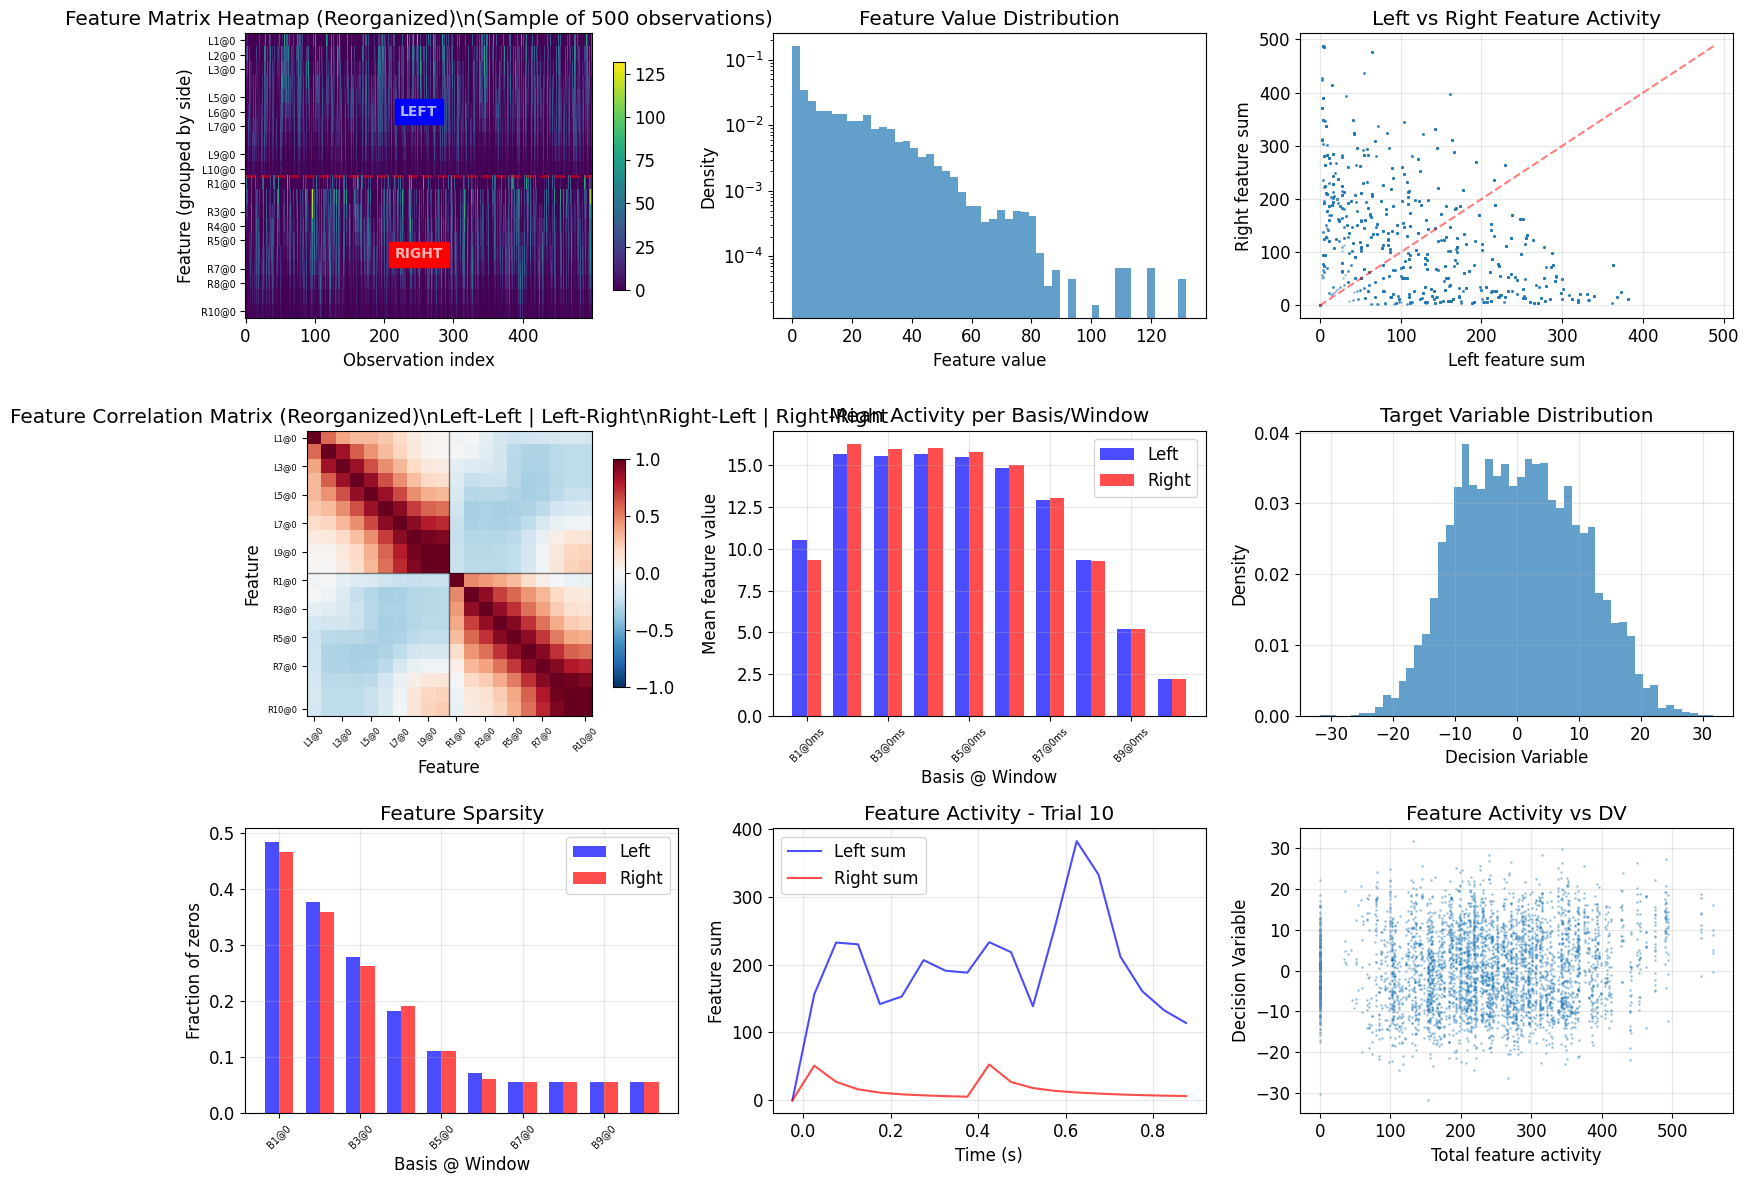

Feature matrix visualization complete (reorganized to avoid checkerboard pattern)!


In [38]:
# Visualize feature matrix structure and patterns
plt.figure(figsize=(16, 12))

# Use helper to extract features correctly
left_features, right_features = helper.extract_features_by_side(X_valid)

# 1. Feature matrix heatmap (sample) - REORGANIZED to avoid checkerboard
plt.subplot(3, 3, 1)
sample_idx = np.random.choice(len(X_valid), size=min(500, len(X_valid)), replace=False)
X_sample = X_valid[sample_idx]

# Reorganize features to group left and right together
left_indices = helper.get_feature_indices(side='left')
right_indices = helper.get_feature_indices(side='right')
reordered_indices = left_indices + right_indices
X_sample_reordered = X_sample[:, reordered_indices]

im = plt.imshow(X_sample_reordered.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(im, shrink=0.8)
plt.xlabel('Observation index')

# Create labels for the reorganized features
left_labels = []
right_labels = []
for w in range(helper.n_windows):
    window_ms = int(helper.time_windows[w] * 1000)
    for b in range(n_basis):
        left_labels.append(f"L{b+1}@{window_ms}")
        right_labels.append(f"R{b+1}@{window_ms}")

reordered_labels = left_labels + right_labels
# Show subset of labels to avoid crowding
n_ticks = min(15, len(reordered_labels))
tick_positions = np.linspace(0, len(reordered_labels)-1, n_ticks).astype(int)
plt.yticks(tick_positions, [reordered_labels[i] for i in tick_positions], fontsize=7)
plt.ylabel('Feature (grouped by side)')
plt.title(f'Feature Matrix Heatmap (Reorganized)\\n(Sample of {len(sample_idx)} observations)')

# Add horizontal line to separate left and right
plt.axhline(y=len(left_indices)-0.5, color='red', linestyle='--', alpha=0.5, linewidth=2)
plt.text(len(sample_idx)//2, len(left_indices)//2, 'LEFT', ha='center', va='center', 
         color='white', fontweight='bold', fontsize=10, backgroundcolor='blue', alpha=0.7)
plt.text(len(sample_idx)//2, len(left_indices) + len(right_indices)//2, 'RIGHT', ha='center', va='center',
         color='white', fontweight='bold', fontsize=10, backgroundcolor='red', alpha=0.7)

# 2. Feature distributions
plt.subplot(3, 3, 2)
plt.hist(X_valid.flatten(), bins=50, alpha=0.7, density=True)
plt.xlabel('Feature value')
plt.ylabel('Density')
plt.title('Feature Value Distribution')
plt.yscale('log')

# 3. Left vs Right feature sums (using corrected extraction)
plt.subplot(3, 3, 3)
left_sums = left_features.sum(axis=1)
right_sums = right_features.sum(axis=1)
plt.scatter(left_sums, right_sums, alpha=0.3, s=1)
plt.xlabel('Left feature sum')
plt.ylabel('Right feature sum')
plt.title('Left vs Right Feature Activity')
plt.plot([0, max(left_sums.max(), right_sums.max())], [0, max(left_sums.max(), right_sums.max())], 'r--', alpha=0.5)
plt.grid(True, alpha=0.3)

# 4. Feature correlation matrix - REORGANIZED
plt.subplot(3, 3, 4)
# Reorder the features for correlation matrix
X_reordered = X_valid[:, reordered_indices]
feature_corr = np.corrcoef(X_reordered.T)

im = plt.imshow(feature_corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, shrink=0.8)

# Add lines to separate left/right blocks
plt.axhline(y=len(left_indices)-0.5, color='black', linestyle='-', alpha=0.5, linewidth=1)
plt.axvline(x=len(left_indices)-0.5, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Show subset of labels
n_ticks = min(10, len(reordered_labels))
tick_positions = np.linspace(0, len(reordered_labels)-1, n_ticks).astype(int)
plt.xticks(tick_positions, [reordered_labels[i] for i in tick_positions], rotation=45, fontsize=6)
plt.yticks(tick_positions, [reordered_labels[i] for i in tick_positions], fontsize=6)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Feature Correlation Matrix (Reorganized)\\nLeft-Left | Left-Right\\nRight-Left | Right-Right')

# 5. Mean feature activity per basis function and window
plt.subplot(3, 3, 5)
# Calculate mean activity for each window and basis
mean_activities = []
labels = []
for w in range(helper.n_windows):
    for b in range(n_basis):
        left_idx = helper.get_feature_indices(window_idx=w, side='left', basis_idx=b)[0]
        right_idx = helper.get_feature_indices(window_idx=w, side='right', basis_idx=b)[0]
        mean_activities.append([X_valid[:, left_idx].mean(), X_valid[:, right_idx].mean()])
        labels.append(f"B{b+1}@{int(helper.time_windows[w]*1000)}ms")

mean_activities = np.array(mean_activities)
x_positions = np.arange(len(labels))
bar_width = 0.35
plt.bar(x_positions - bar_width/2, mean_activities[:, 0], bar_width, label='Left', color='blue', alpha=0.7)
plt.bar(x_positions + bar_width/2, mean_activities[:, 1], bar_width, label='Right', color='red', alpha=0.7)
plt.xticks(x_positions[::2], labels[::2], rotation=45, fontsize=7)
plt.xlabel('Basis @ Window')
plt.ylabel('Mean feature value')
plt.title('Mean Activity per Basis/Window')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Target variable distribution
plt.subplot(3, 3, 6)
plt.hist(y_valid, bins=50, alpha=0.7, density=True)
plt.xlabel('Decision Variable')
plt.ylabel('Density')
plt.title('Target Variable Distribution')
plt.grid(True, alpha=0.3)

# 7. Feature sparsity per window
plt.subplot(3, 3, 7)
sparsity_data = []
sparsity_labels = []
for w in range(helper.n_windows):
    window_ms = int(helper.time_windows[w] * 1000)
    for b in range(n_basis):
        left_idx = helper.get_feature_indices(window_idx=w, side='left', basis_idx=b)[0]
        right_idx = helper.get_feature_indices(window_idx=w, side='right', basis_idx=b)[0]
        left_sparsity = (X_valid[:, left_idx] == 0).mean()
        right_sparsity = (X_valid[:, right_idx] == 0).mean()
        sparsity_data.append([left_sparsity, right_sparsity])
        sparsity_labels.append(f"B{b+1}@{window_ms}")

sparsity_data = np.array(sparsity_data)
x_positions = np.arange(len(sparsity_labels))
plt.bar(x_positions - bar_width/2, sparsity_data[:, 0], bar_width, label='Left', color='blue', alpha=0.7)
plt.bar(x_positions + bar_width/2, sparsity_data[:, 1], bar_width, label='Right', color='red', alpha=0.7)
plt.xticks(x_positions[::2], sparsity_labels[::2], rotation=45, fontsize=7)
plt.xlabel('Basis @ Window')
plt.ylabel('Fraction of zeros')
plt.title('Feature Sparsity')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Time series of feature activity (sample trial)
plt.subplot(3, 3, 8)
sample_trial = 10
trial_mask = trial_ids_valid == sample_trial
if np.any(trial_mask):
    trial_times = time_bins_valid[trial_mask]
    trial_features = X_valid[trial_mask]
    # Use helper to extract left/right correctly
    trial_left, trial_right = helper.extract_features_by_side(trial_features)
    plt.plot(trial_times, trial_left.sum(axis=1), 'b-', alpha=0.7, label='Left sum')
    plt.plot(trial_times, trial_right.sum(axis=1), 'r-', alpha=0.7, label='Right sum')
    plt.xlabel('Time (s)')
    plt.ylabel('Feature sum')
    plt.title(f'Feature Activity - Trial {sample_trial}')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 9. Feature vs target scatter (total activity)
plt.subplot(3, 3, 9)
total_activity = X_valid.sum(axis=1)
plt.scatter(total_activity, y_valid, alpha=0.3, s=1)
plt.xlabel('Total feature activity')
plt.ylabel('Decision Variable')
plt.title('Feature Activity vs DV')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature matrix visualization complete (reorganized to avoid checkerboard pattern)!")

## 5. Train Model

In [39]:
## Fit ElasticNetCV Model

# Split into train/validation sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42
)

# No longer need to add noise - cosine clicks provide natural smoothness
print("Using smooth features from 3ms cosine clicks - no artificial noise needed")

# Configure ElasticNetCV with l1_ratio=0.95 (95% L1, 5% L2)
model = ElasticNetCV(
    l1_ratio=0.95,  # 95% Lasso, 5% Ridge
    cv=10,  # 10-fold cross-validation
    n_alphas=100,  # Test 100 regularization values
    max_iter=10000,  # Ensure convergence
    selection='cyclic',  # Stable for low dimensions
    random_state=42
)

# Fit the model on training data - using smooth features directly
print('Fitting ElasticNetCV model with l1_ratio=0.95 (smooth cosine features)...')
model.fit(X_train, y_train)

# Get predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Extract coefficients
coefficients = model.coef_
n_features_selected = np.sum(coefficients != 0)

# Calculate metrics
train_corr = np.corrcoef(y_train, y_pred_train)[0,1]
test_corr = np.corrcoef(y_test, y_pred_test)[0,1]
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'\nModel Performance:')
print(f'Selected features: {n_features_selected}/{len(coefficients)}')
print(f'Optimal alpha: {model.alpha_:.6f}')
print(f'\nTrain set ({len(y_train)} samples):')
print(f'  Correlation: {train_corr:.4f}')
print(f'  R²: {train_r2:.4f}')
print(f'  RMSE/std: {train_rmse/np.std(y_train):.4f}')
print(f'\nTest set ({len(y_test)} samples):')
print(f'  Correlation: {test_corr:.4f}')
print(f'  R²: {test_r2:.4f}')
print(f'  RMSE/std: {test_rmse/np.std(y_test):.4f}')
print('\nNote: Using 3ms cosine click kernels at 1ms resolution')

Using smooth features from 3ms cosine clicks - no artificial noise needed
Fitting ElasticNetCV model with l1_ratio=0.95 (smooth cosine features)...

Model Performance:
Selected features: 12/20
Optimal alpha: 0.657185

Train set (3412 samples):
  Correlation: 0.6267
  R²: 0.3927
  RMSE/std: 0.7793

Test set (854 samples):
  Correlation: 0.6341
  R²: 0.4002
  RMSE/std: 0.7745

Note: Using 3ms cosine click kernels at 1ms resolution


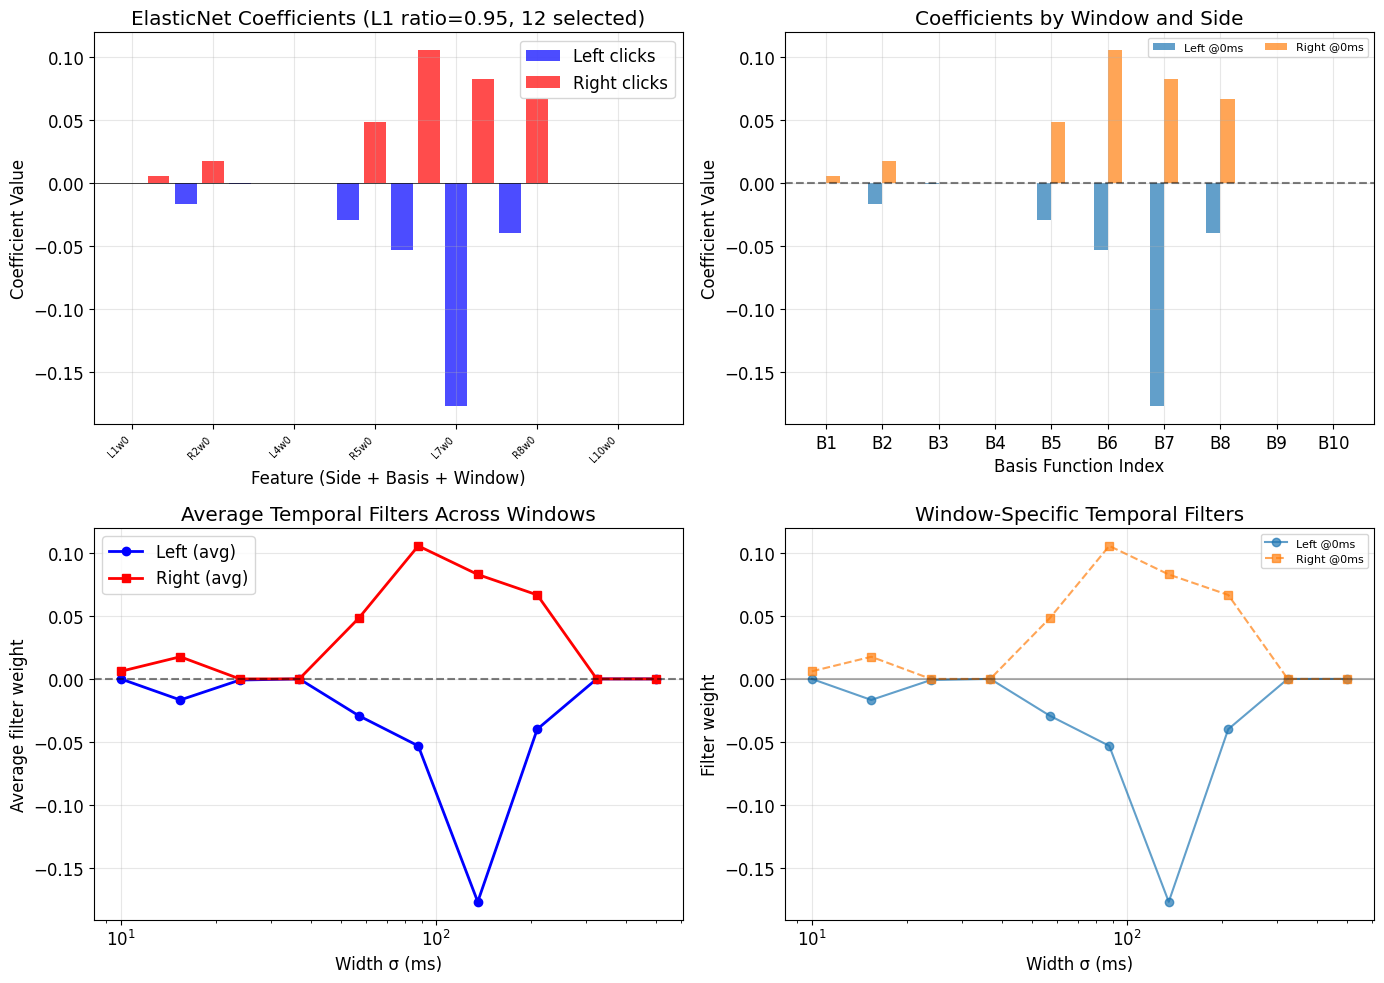

\nSelected features: 12
\nDetailed coefficient breakdown by window:
\nWindow @0ms:
  Basis 1 (σ=10.0ms):
    Right: 0.0060
  Basis 2 (σ=15.4ms):
    Left: -0.0167
    Right: 0.0176
  Basis 3 (σ=23.9ms):
    Left: -0.0009
  Basis 5 (σ=56.9ms):
    Left: -0.0292
    Right: 0.0483
  Basis 6 (σ=87.9ms):
    Left: -0.0532
    Right: 0.1057
  Basis 7 (σ=135.7ms):
    Left: -0.1771
    Right: 0.0830
  Basis 8 (σ=209.6ms):
    Left: -0.0399
    Right: 0.0667


In [40]:
## Visualize Model Coefficients (Multi-Window)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All coefficient values with proper labels
ax = axes[0, 0]
x_pos = np.arange(len(coefficients))

# Color code by side using helper
colors = []
for i in range(len(coefficients)):
    if i in helper.get_feature_indices(side='left'):
        colors.append('blue')
    else:
        colors.append('red')

bars = ax.bar(x_pos, coefficients, color=colors, alpha=0.7)

# Create custom x-tick labels using helper
xtick_labels = helper.get_feature_labels(short=True)
# Show subset of labels to avoid crowding
tick_positions = range(0, len(xtick_labels), 3)
ax.set_xticks(tick_positions)
ax.set_xticklabels([xtick_labels[i] for i in tick_positions], rotation=45, ha='right', fontsize=7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Feature (Side + Basis + Window)')
ax.set_ylabel('Coefficient Value')
ax.set_title(f'ElasticNet Coefficients (L1 ratio=0.95, {n_features_selected} selected)')
ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Left clicks'),
                   Patch(facecolor='red', alpha=0.7, label='Right clicks')]
ax.legend(handles=legend_elements)

# Plot 2: Coefficients organized by window
ax = axes[0, 1]
left_coef_matrix, right_coef_matrix = helper.extract_coefficients_by_side(coefficients)

# Plot coefficients for each window
x = np.arange(n_basis)
bar_width = 0.25
for w in range(helper.n_windows):
    window_ms = int(helper.time_windows[w] * 1000)
    offset = (w - helper.n_windows/2) * bar_width
    ax.bar(x + offset, left_coef_matrix[w, :], bar_width, 
           label=f'Left @{window_ms}ms', alpha=0.7, color=f'C{w*2}')
    ax.bar(x + offset + helper.n_windows * bar_width, right_coef_matrix[w, :], bar_width,
           label=f'Right @{window_ms}ms', alpha=0.7, color=f'C{w*2+1}')

ax.set_xlabel('Basis Function Index')
ax.set_ylabel('Coefficient Value')
ax.set_title('Coefficients by Window and Side')
ax.set_xticks(x)
ax.set_xticklabels([f'B{i+1}' for i in range(n_basis)])
ax.legend(fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Plot 3: Average temporal filters across windows
ax = axes[1, 0]
# Average coefficients across windows for each basis function
left_avg = left_coef_matrix.mean(axis=0)
right_avg = right_coef_matrix.mean(axis=0)

ax.plot(widths * 1000, left_avg, 'b-', marker='o', label='Left (avg)', linewidth=2)
ax.plot(widths * 1000, right_avg, 'r-', marker='s', label='Right (avg)', linewidth=2)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Width σ (ms)')
ax.set_ylabel('Average filter weight')
ax.set_title('Average Temporal Filters Across Windows')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 4: Window-specific temporal filters
ax = axes[1, 1]
for w in range(helper.n_windows):
    window_ms = int(helper.time_windows[w] * 1000)
    ax.plot(widths * 1000, left_coef_matrix[w, :], '-', marker='o', 
            label=f'Left @{window_ms}ms', alpha=0.7, linewidth=1.5)
    ax.plot(widths * 1000, right_coef_matrix[w, :], '--', marker='s',
            label=f'Right @{window_ms}ms', alpha=0.7, linewidth=1.5)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Width σ (ms)')
ax.set_ylabel('Filter weight')
ax.set_title('Window-Specific Temporal Filters')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Print selected features with proper window information
selected_idx = np.where(coefficients != 0)[0]
if len(selected_idx) > 0:
    print(f'\\nSelected features: {n_features_selected}')
    print(f'\\nDetailed coefficient breakdown by window:')
    
    for w in range(helper.n_windows):
        window_ms = int(helper.time_windows[w] * 1000)
        print(f'\\nWindow @{window_ms}ms:')
        
        for b in range(n_basis):
            left_idx = helper.get_feature_indices(window_idx=w, side='left', basis_idx=b)[0]
            right_idx = helper.get_feature_indices(window_idx=w, side='right', basis_idx=b)[0]
            
            left_coef = coefficients[left_idx]
            right_coef = coefficients[right_idx]
            
            if left_coef != 0 or right_coef != 0:
                print(f'  Basis {b+1} (σ={widths[b]*1000:.1f}ms):')
                if left_coef != 0:
                    print(f'    Left: {left_coef:.4f}')
                if right_coef != 0:
                    print(f'    Right: {right_coef:.4f}')

## 6. Visualizations

Create comprehensive visualizations of the GLM results, including cross-validation performance, regularization behavior, learned temporal filters, and model fit quality.

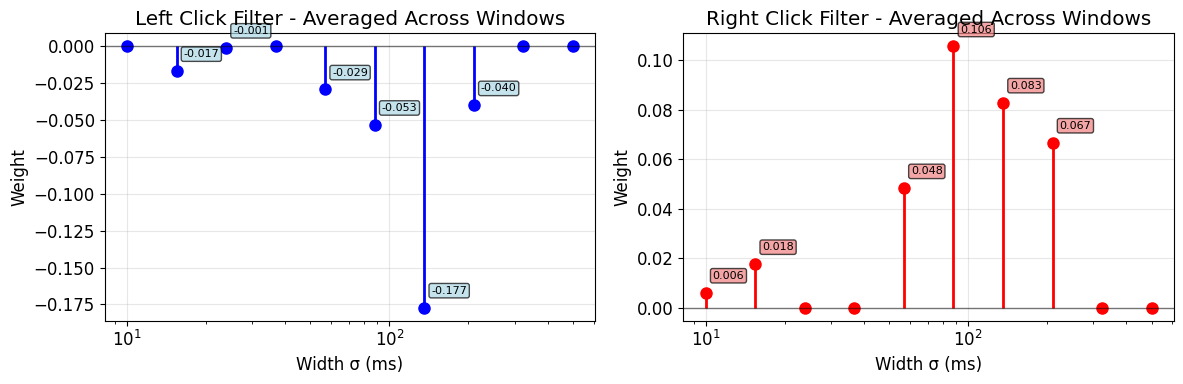

=== LEARNED TEMPORAL FILTERS (MULTI-WINDOW) ===

Window @0ms:
  Left features selected: 6/10
  Right features selected: 6/10
  Active left widths: [ 15.4  23.9  56.9  87.9 135.7 209.6] ms
  Active right widths: [ 10.   15.4  56.9  87.9 135.7 209.6] ms

Total filter strength across all windows:
  Left: 0.3171
  Right: 0.3273
  L/R ratio: 0.97

✓ Temporal filters reveal learned click-to-DV relationships across multiple time windows


In [41]:
# 3. Learned temporal filters (multi-window corrected)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Extract coefficients properly using helper
left_coef_matrix, right_coef_matrix = helper.extract_coefficients_by_side(coefficients)

# Average across windows for visualization (or could show each window separately)
left_coefs_avg = left_coef_matrix.mean(axis=0)
right_coefs_avg = right_coef_matrix.mean(axis=0)

# Left click filter
colors_left = ['blue' if c != 0 else 'lightgray' for c in left_coefs_avg]
markerline, stemlines, baseline = ax1.stem(widths*1000, left_coefs_avg, basefmt=' ')
plt.setp(markerline, color='blue', markersize=8)
plt.setp(stemlines, colors=colors_left, linewidth=2)
ax1.set_xlabel('Width σ (ms)')
ax1.set_ylabel('Weight')
ax1.set_title('Left Click Filter - Averaged Across Windows')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, left_coefs_avg)):
    if coef != 0:
        ax1.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))

# Right click filter  
colors_right = ['red' if c != 0 else 'lightgray' for c in right_coefs_avg]
markerline, stemlines, baseline = ax2.stem(widths*1000, right_coefs_avg, basefmt=' ')
plt.setp(markerline, color='red', markersize=8)
plt.setp(stemlines, colors=colors_right, linewidth=2)
ax2.set_xlabel('Width σ (ms)')
ax2.set_ylabel('Weight')
ax2.set_title('Right Click Filter - Averaged Across Windows')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, right_coefs_avg)):
    if coef != 0:
        ax2.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

# Summary of learned filters
print("=== LEARNED TEMPORAL FILTERS (MULTI-WINDOW) ===")

# Show window-specific details
for w in range(helper.n_windows):
    window_ms = int(helper.time_windows[w] * 1000)
    left_selected = np.sum(left_coef_matrix[w, :] != 0)
    right_selected = np.sum(right_coef_matrix[w, :] != 0)
    print(f"\nWindow @{window_ms}ms:")
    print(f"  Left features selected: {left_selected}/{n_basis}")
    print(f"  Right features selected: {right_selected}/{n_basis}")
    
    if left_selected > 0:
        left_active_widths = widths[left_coef_matrix[w, :] != 0] * 1000
        print(f"  Active left widths: {left_active_widths.round(1)} ms")
    
    if right_selected > 0:
        right_active_widths = widths[right_coef_matrix[w, :] != 0] * 1000
        print(f"  Active right widths: {right_active_widths.round(1)} ms")

# Overall summary
left_total = np.sum(np.abs(left_coef_matrix))
right_total = np.sum(np.abs(right_coef_matrix))
print(f"\nTotal filter strength across all windows:")
print(f"  Left: {left_total:.4f}")
print(f"  Right: {right_total:.4f}")
print(f"  L/R ratio: {left_total/right_total:.2f}" if right_total > 0 else "  L/R ratio: inf")

print("\n✓ Temporal filters reveal learned click-to-DV relationships across multiple time windows")

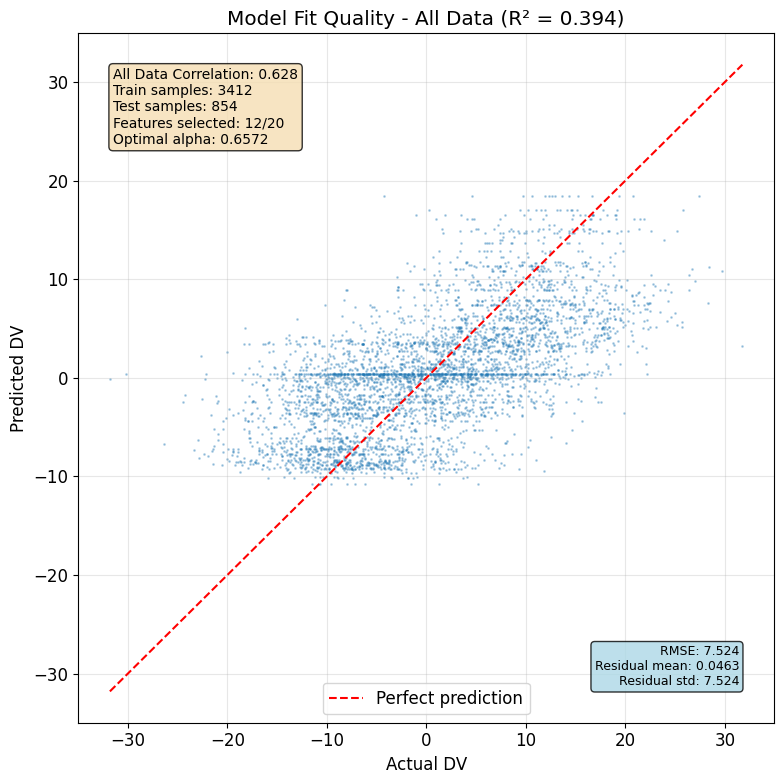

Total data points plotted: 4266


In [42]:
# 4. Model fit quality - INCLUDING ALL DATA
# Combine train and test data for comprehensive view
y_all = np.concatenate([y_train, y_test])
y_pred_all = np.concatenate([y_pred_train, y_pred_test])

plt.figure(figsize=(8, 8))
plt.scatter(y_all, y_pred_all, alpha=0.3, s=1)
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()],
         'r--', label='Perfect prediction')
plt.xlabel('Actual DV')
plt.ylabel('Predicted DV')

# Calculate R² for all data
from sklearn.metrics import r2_score
r2_all = r2_score(y_all, y_pred_all)
plt.title(f'Model Fit Quality - All Data (R² = {r2_all:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add performance metrics as text
correlation_all = np.corrcoef(y_all, y_pred_all)[0,1]
textstr = f'''All Data Correlation: {correlation_all:.3f}
Train samples: {len(y_train)}
Test samples: {len(y_test)}
Features selected: {n_features_selected}/{len(coefficients)}
Optimal alpha: {model.alpha_:.4f}'''

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add diagonal statistics for all data
residuals = y_all - y_pred_all
plt.text(0.95, 0.05, f'RMSE: {np.sqrt(np.mean(residuals**2)):.3f}\n'
                      f'Residual mean: {residuals.mean():.4f}\n'
                      f'Residual std: {residuals.std():.3f}',
         transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Total data points plotted: {len(y_all)}")

## 7. Response Function Analysis

Construct and visualize the temporal response functions that show how clicks influence the decision variable over time.

In [43]:
# Construct full temporal response functions using multi-window coefficients
# Time range for response function visualization
t = np.linspace(-0.05, 1.5, 1550)  # -50ms to 1500ms at 1ms resolution

# Use helper to properly reconstruct response functions from multi-window coefficients
left_response, right_response = helper.reconstruct_response_functions(
    coefficients, centers, widths, t
)

print(f"Response functions constructed from {n_features_selected} selected features")
print(f"Multi-window configuration: {[w*1000 for w in helper.time_windows]}ms")
print(f"Left response peak: {left_response.max():.4f} at {t[left_response.argmax()]*1000:.1f}ms")
print(f"Right response peak: {right_response.max():.4f} at {t[right_response.argmax()]*1000:.1f}ms")

# Also show contribution from each window
left_coef_matrix, right_coef_matrix = helper.extract_coefficients_by_side(coefficients)
print(f"\nContributions by window:")
for w in range(helper.n_windows):
    window_ms = int(helper.time_windows[w] * 1000)
    left_nonzero = np.sum(left_coef_matrix[w, :] != 0)
    right_nonzero = np.sum(right_coef_matrix[w, :] != 0)
    print(f"  Window @{window_ms}ms: {left_nonzero} left, {right_nonzero} right active coefficients")

Response functions constructed from 12 selected features
Multi-window configuration: [0]ms
Left response peak: 0.0000 at -50.0ms
Right response peak: 0.8900 at 147.1ms

Contributions by window:
  Window @0ms: 6 left, 6 right active coefficients


### 7.1 Combined Response Functions

NameError: name 'left_coefs' is not defined

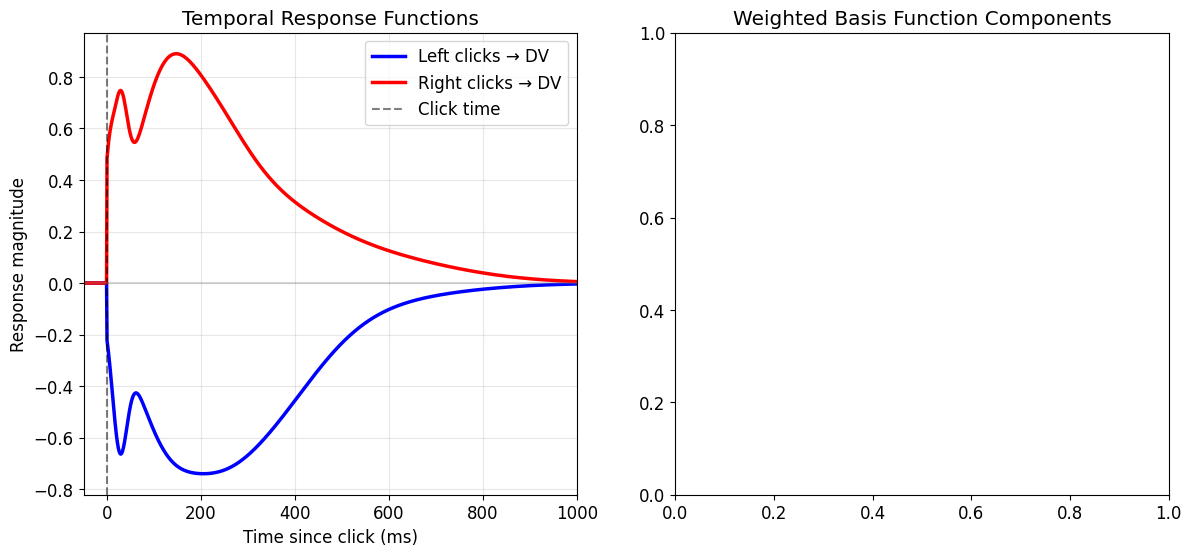

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Combined response functions
ax1.plot(t*1000, left_response, 'b-', linewidth=2.5, label='Left clicks → DV')
ax1.plot(t*1000, right_response, 'r-', linewidth=2.5, label='Right clicks → DV')
ax1.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax1.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax1.set_xlabel('Time since click (ms)')
ax1.set_ylabel('Response magnitude')
ax1.set_title('Temporal Response Functions')
ax1.set_xlim(-50, 1000)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Right panel: Individual weighted components
ax2.set_title('Weighted Basis Function Components')
for i in range(n_basis):
    if left_coefs[i] != 0:
        weighted_basis = left_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax2.plot(t*1000, weighted_basis, 'b-', alpha=0.5, linewidth=1, 
                label=f'L{widths[i]*1000:.0f}ms' if i < 3 else '')
    if right_coefs[i] != 0:
        weighted_basis = right_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax2.plot(t*1000, weighted_basis, 'r-', alpha=0.5, linewidth=1,
                label=f'R{widths[i]*1000:.0f}ms' if i < 3 else '')

ax2.plot(t*1000, left_response, 'b-', linewidth=2, alpha=0.8, label='Left sum')
ax2.plot(t*1000, right_response, 'r-', linewidth=2, alpha=0.8, label='Right sum')
ax2.axvline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax2.set_xlabel('Time since click (ms)')
ax2.set_ylabel('Response magnitude')
ax2.set_xlim(-50, 1000)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.2 Cumulative Response Analysis

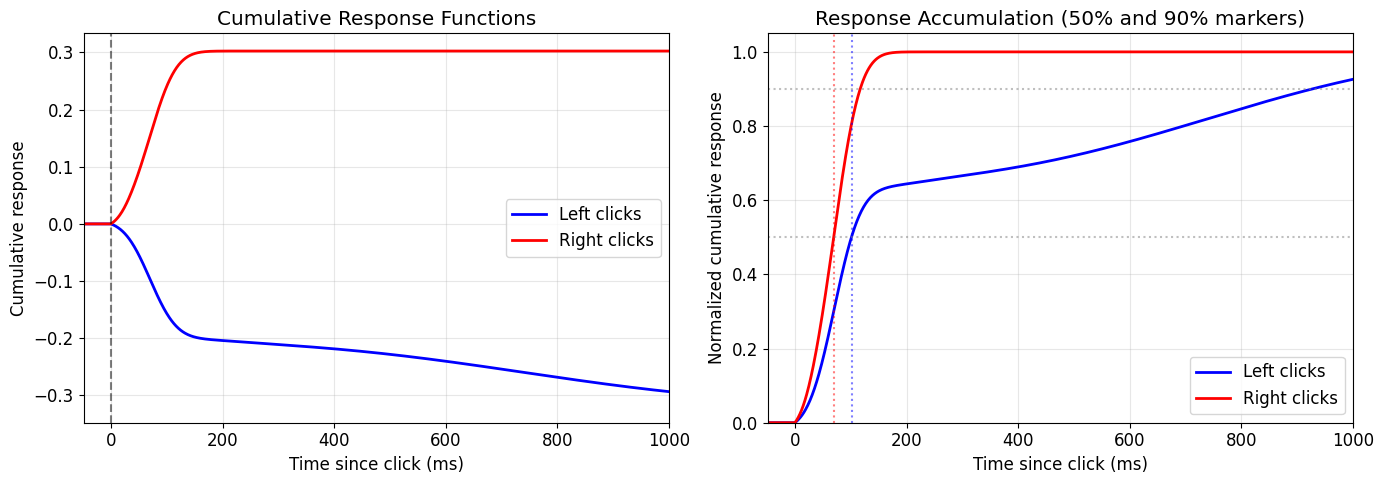

Response latencies (time to reach percentage of total response):
Left:  50% at 101.1ms, 90% at 927.6ms
Right: 50% at 69.1ms, 90% at 116.1ms


In [ ]:
# Calculate cumulative response functions
dt = t[1] - t[0]  # Time step
left_cumulative = np.cumsum(left_response) * dt
right_cumulative = np.cumsum(right_response) * dt

# Normalize to [0, 1] for percentage analysis
left_cumulative_norm = left_cumulative / (left_cumulative[-1] if left_cumulative[-1] != 0 else 1)
right_cumulative_norm = right_cumulative / (right_cumulative[-1] if right_cumulative[-1] != 0 else 1)

# Find key time points
left_50_idx = np.searchsorted(left_cumulative_norm, 0.5)
left_90_idx = np.searchsorted(left_cumulative_norm, 0.9)
right_50_idx = np.searchsorted(right_cumulative_norm, 0.5)
right_90_idx = np.searchsorted(right_cumulative_norm, 0.9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Absolute cumulative response
ax1.plot(t*1000, left_cumulative, 'b-', linewidth=2, label='Left clicks')
ax1.plot(t*1000, right_cumulative, 'r-', linewidth=2, label='Right clicks')
ax1.axvline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Time since click (ms)')
ax1.set_ylabel('Cumulative response')
ax1.set_title('Cumulative Response Functions')
ax1.set_xlim(-50, 1000)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Normalized cumulative response with markers
ax2.plot(t*1000, left_cumulative_norm, 'b-', linewidth=2, label='Left clicks')
ax2.plot(t*1000, right_cumulative_norm, 'r-', linewidth=2, label='Right clicks')
ax2.axvline(t[left_50_idx]*1000, color='blue', linestyle=':', alpha=0.5)
ax2.axvline(t[right_50_idx]*1000, color='red', linestyle=':', alpha=0.5)
ax2.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(0.9, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Time since click (ms)')
ax2.set_ylabel('Normalized cumulative response')
ax2.set_title('Response Accumulation (50% and 90% markers)')
ax2.set_xlim(-50, 1000)
ax2.set_ylim(0, 1.05)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Response latencies (time to reach percentage of total response):")
print(f"Left:  50% at {t[left_50_idx]*1000:.1f}ms, 90% at {t[left_90_idx]*1000:.1f}ms")
print(f"Right: 50% at {t[right_50_idx]*1000:.1f}ms, 90% at {t[right_90_idx]*1000:.1f}ms")

### 7.3 Response Function Characteristics

In [ ]:
# Calculate key metrics
left_peak_idx = left_response.argmax()
right_peak_idx = right_response.argmax()

left_peak_time = t[left_peak_idx] * 1000
right_peak_time = t[right_peak_idx] * 1000
left_peak_mag = left_response[left_peak_idx]
right_peak_mag = right_response[right_peak_idx]

# Find response duration (time to decay to 10% of peak)
left_10pct = 0.1 * left_peak_mag
right_10pct = 0.1 * right_peak_mag

left_duration_idx = np.where(left_response[left_peak_idx:] < left_10pct)[0]
right_duration_idx = np.where(right_response[right_peak_idx:] < right_10pct)[0]

left_duration = t[left_peak_idx + left_duration_idx[0]]*1000 if len(left_duration_idx) > 0 else 1500
right_duration = t[right_peak_idx + right_duration_idx[0]]*1000 if len(right_duration_idx) > 0 else 1500

# Total integrated response
left_total = np.trapz(left_response[t >= 0], t[t >= 0])
right_total = np.trapz(right_response[t >= 0], t[t >= 0])

# Asymmetry index
asymmetry = (left_total - right_total) / (left_total + right_total) if (left_total + right_total) > 0 else 0

# Create summary table
metrics_data = {
    'Metric': ['Peak Time (ms)', 'Peak Magnitude', 'Duration to 10% (ms)', 
               'Total Response (area)', '50% Latency (ms)', '90% Latency (ms)'],
    'Left Clicks': [f'{left_peak_time:.1f}', f'{left_peak_mag:.4f}', f'{left_duration:.1f}',
                    f'{left_total:.4f}', f'{t[left_50_idx]*1000:.1f}', f'{t[left_90_idx]*1000:.1f}'],
    'Right Clicks': [f'{right_peak_time:.1f}', f'{right_peak_mag:.4f}', f'{right_duration:.1f}',
                     f'{right_total:.4f}', f'{t[right_50_idx]*1000:.1f}', f'{t[right_90_idx]*1000:.1f}']
}

metrics_df = pd.DataFrame(metrics_data)
print("Response Function Characteristics:")
print(metrics_df.to_string(index=False))
print(f"\nAsymmetry Index (L-R)/(L+R): {asymmetry:.3f}")
print("Positive = left-biased, Negative = right-biased")

Response Function Characteristics:
               Metric Left Clicks Right Clicks
       Peak Time (ms)       -50.0         69.1
       Peak Magnitude      0.0000       3.2345
 Duration to 10% (ms)         0.0        149.1
Total Response (area)     -0.3168       0.3022
     50% Latency (ms)       101.1         69.1
     90% Latency (ms)       927.6        116.1

Asymmetry Index (L-R)/(L+R): 0.000
Positive = left-biased, Negative = right-biased


### 7.4 Comparison with Raw Basis Functions

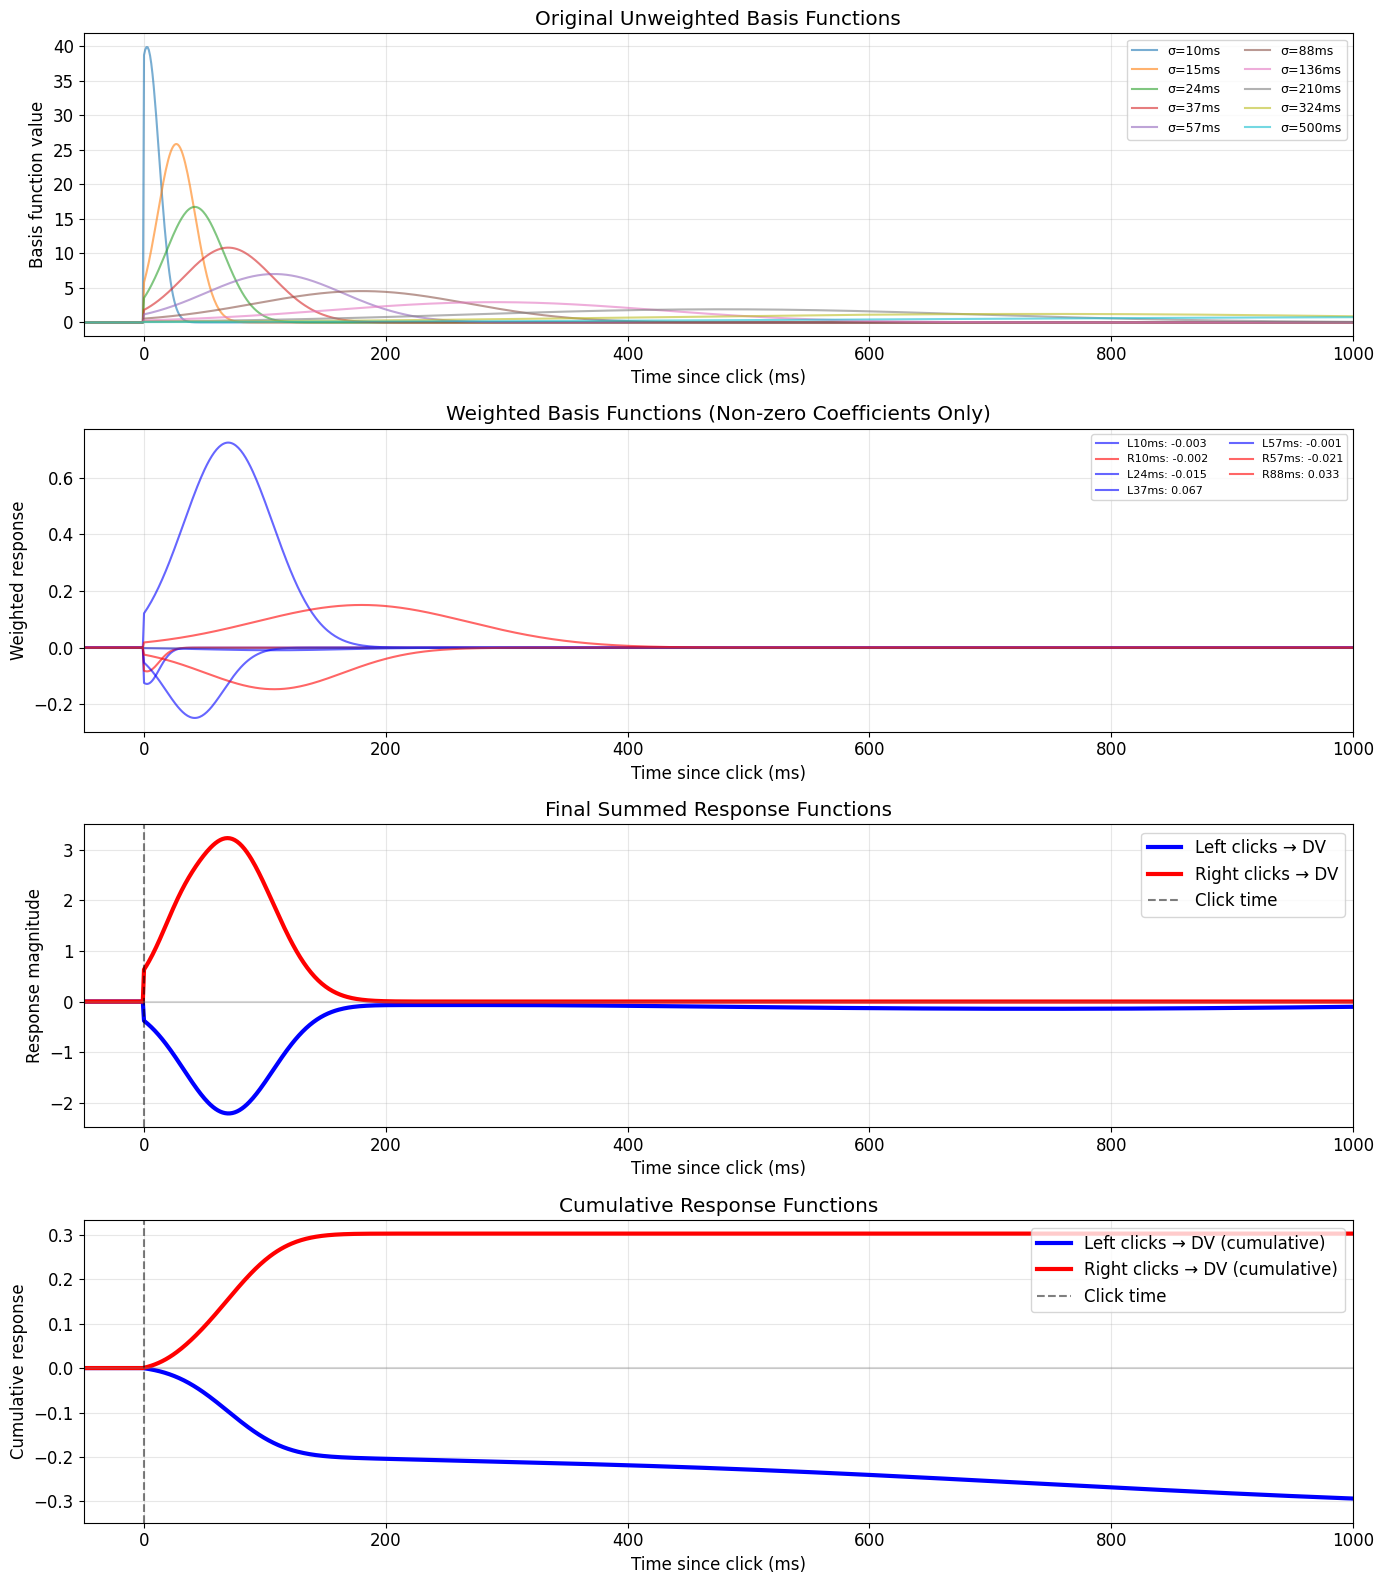

Regularization selected 9/20 features
This sparse selection shapes the temporal filter to focus on key timescales


In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Top: Original unweighted basis functions
ax = axes[0]
for i in range(n_basis):
    basis = gaussian_basis(t, centers[i], widths[i], causal=True)
    ax.plot(t*1000, basis, alpha=0.6, linewidth=1.5, 
            label=f'σ={widths[i]*1000:.0f}ms')
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Basis function value')
ax.set_title('Original Unweighted Basis Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right', ncol=2, fontsize=9)
ax.grid(True, alpha=0.3)

# Middle: Weighted basis functions
ax = axes[1]
for i in range(n_basis):
    if left_coefs[i] != 0:
        weighted = left_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax.plot(t*1000, weighted, 'b-', alpha=0.6, linewidth=1.5,
                label=f'L{widths[i]*1000:.0f}ms: {left_coefs[i]:.3f}')
    if right_coefs[i] != 0:
        weighted = right_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax.plot(t*1000, weighted, 'r-', alpha=0.6, linewidth=1.5,
                label=f'R{widths[i]*1000:.0f}ms: {right_coefs[i]:.3f}')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Weighted response')
ax.set_title('Weighted Basis Functions (Non-zero Coefficients Only)')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right', ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)

# Third: Final summed response functions
ax = axes[2]
ax.plot(t*1000, left_response, 'b-', linewidth=3, label='Left clicks → DV')
ax.plot(t*1000, right_response, 'r-', linewidth=3, label='Right clicks → DV')
# ax.fill_between(t*1000, 0, left_response, where=(left_response > 0), 
#                  alpha=0.3, color='blue')
# ax.fill_between(t*1000, 0, right_response, where=(right_response > 0), 
#                  alpha=0.3, color='red')
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Response magnitude')
ax.set_title('Final Summed Response Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Bottom: Cumulative Response Functions
ax = axes[3]
# Calculate cumulative responses
dt = t[1] - t[0]
left_cumulative = np.cumsum(left_response) * dt
right_cumulative = np.cumsum(right_response) * dt

ax.plot(t*1000, left_cumulative, 'b-', linewidth=3, label='Left clicks → DV (cumulative)')
ax.plot(t*1000, right_cumulative, 'r-', linewidth=3, label='Right clicks → DV (cumulative)')
# ax.fill_between(t*1000, 0, left_cumulative, where=(left_cumulative > 0), 
#                  alpha=0.3, color='blue')
# ax.fill_between(t*1000, 0, right_cumulative, where=(right_cumulative > 0), 
#                  alpha=0.3, color='red')
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Cumulative response')
ax.set_title('Cumulative Response Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Regularization selected {n_features_selected}/{2*n_basis} features")
print(f"This sparse selection shapes the temporal filter to focus on key timescales")

## 8. Striation Analysis

Investigating the discrete patterns in model predictions.

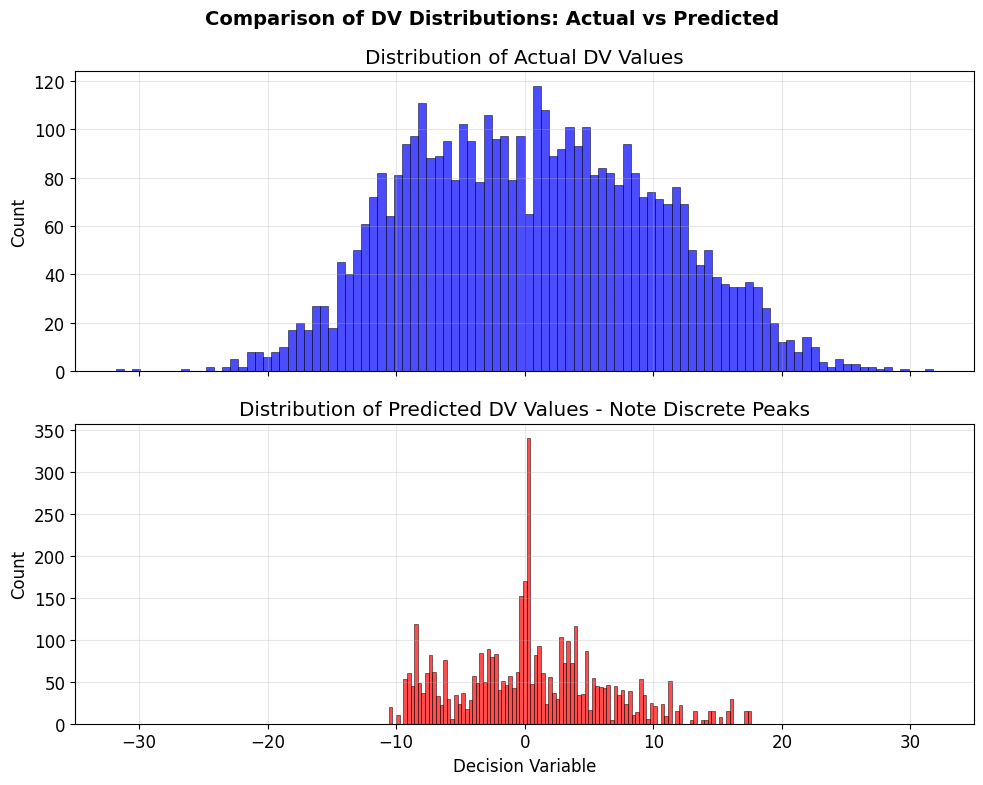

Actual DV - Unique values: 4266
Predicted DV - Unique values: 485
Reduction in unique values: 3781


In [ ]:
# Compare distributions of actual vs predicted DV values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Actual DV distribution
ax1.hist(y_all, bins=100, alpha=0.7, color='blue', edgecolor='black', linewidth=0.5)
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Actual DV Values')
ax1.grid(True, alpha=0.3)

# Predicted DV distribution  
ax2.hist(y_pred_all, bins=100, alpha=0.7, color='red', edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Decision Variable')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Predicted DV Values - Note Discrete Peaks')
ax2.grid(True, alpha=0.3)

plt.suptitle('Comparison of DV Distributions: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print(f"Actual DV - Unique values: {len(np.unique(y_all))}")
print(f"Predicted DV - Unique values: {len(np.unique(y_pred_all))}")
print(f"Reduction in unique values: {len(np.unique(y_all)) - len(np.unique(y_pred_all))}")

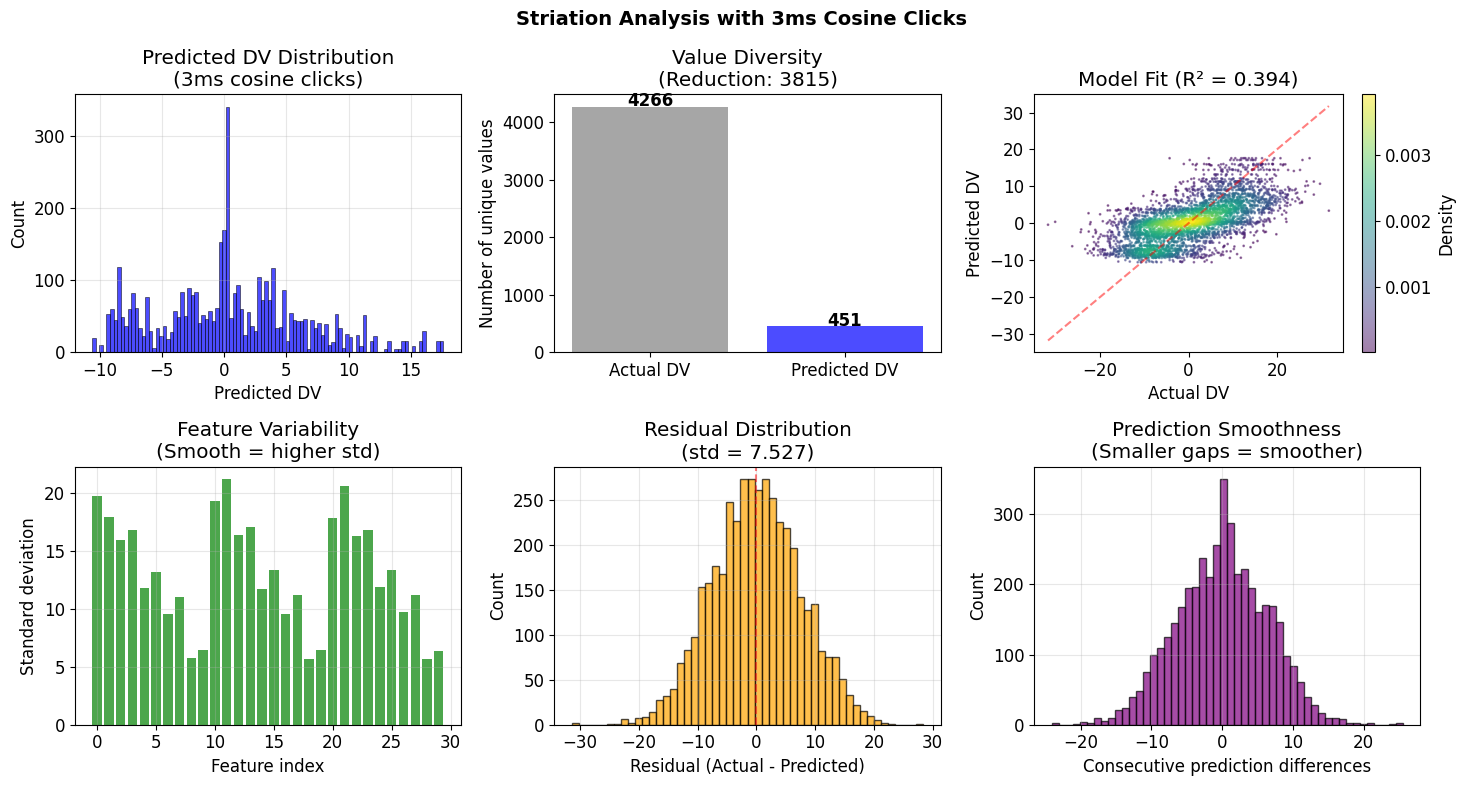

=== STRIATION REDUCTION METRICS ===
Unique predicted values: 451 (out of 4266 total)
Prediction value diversity: 10.6%
Mean consecutive difference: 5.090374
Median consecutive difference: 4.373631

Discrete clusters detected (DBSCAN): 60
(Fewer clusters = less striation)

✓ Smooth click representation reduces striations in predictions!


In [ ]:
# Analyze striation reduction with smooth click representation
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Combine all predictions for analysis
y_all = np.concatenate([y_train, y_test])
y_pred_all = np.concatenate([y_pred_train, y_pred_test])

# 1. Distribution of predicted values - should be smoother
ax = axes[0, 0]
ax.hist(y_pred_all, bins=100, alpha=0.7, color='blue', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Predicted DV')
ax.set_ylabel('Count')
ax.set_title('Predicted DV Distribution\n(3ms cosine clicks)')
ax.grid(True, alpha=0.3)

# 2. Unique values analysis
unique_actual = len(np.unique(np.round(y_all, 6)))
unique_pred = len(np.unique(np.round(y_pred_all, 6)))
ax = axes[0, 1]
ax.bar(['Actual DV', 'Predicted DV'], [unique_actual, unique_pred], 
       color=['gray', 'blue'], alpha=0.7)
ax.set_ylabel('Number of unique values')
ax.set_title(f'Value Diversity\n(Reduction: {unique_actual - unique_pred})')
for i, v in enumerate([unique_actual, unique_pred]):
    ax.text(i, v + 10, str(v), ha='center', fontweight='bold')

# 3. Scatter plot colored by density
from scipy.stats import gaussian_kde
xy = np.vstack([y_all, y_pred_all])
z = gaussian_kde(xy)(xy)
ax = axes[0, 2]
scatter = ax.scatter(y_all, y_pred_all, c=z, s=1, cmap='viridis', alpha=0.5)
ax.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', alpha=0.5)
ax.set_xlabel('Actual DV')
ax.set_ylabel('Predicted DV')
ax.set_title(f'Model Fit (R² = {r2_score(y_all, y_pred_all):.3f})')
plt.colorbar(scatter, ax=ax, label='Density')

# 4. Feature continuity analysis
ax = axes[1, 0]
feature_stds = X_valid.std(axis=0)
ax.bar(range(len(feature_stds)), feature_stds, color='green', alpha=0.7)
ax.set_xlabel('Feature index')
ax.set_ylabel('Standard deviation')
ax.set_title('Feature Variability\n(Smooth = higher std)')
ax.grid(True, alpha=0.3)

# 5. Residual distribution
residuals = y_all - y_pred_all
ax = axes[1, 1]
ax.hist(residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
ax.set_xlabel('Residual (Actual - Predicted)')
ax.set_ylabel('Count')
ax.set_title(f'Residual Distribution\n(std = {residuals.std():.3f})')
ax.axvline(0, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

# 6. Prediction smoothness - consecutive differences
sorted_idx = np.argsort(y_all)
y_sorted = y_all[sorted_idx]
y_pred_sorted = y_pred_all[sorted_idx]
pred_diffs = np.diff(y_pred_sorted)
ax = axes[1, 2]
ax.hist(pred_diffs, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.set_xlabel('Consecutive prediction differences')
ax.set_ylabel('Count')
ax.set_title('Prediction Smoothness\n(Smaller gaps = smoother)')
ax.grid(True, alpha=0.3)

plt.suptitle('Striation Analysis with 3ms Cosine Clicks', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print quantitative metrics
print("=== STRIATION REDUCTION METRICS ===")
print(f"Unique predicted values: {unique_pred} (out of {len(y_pred_all)} total)")
print(f"Prediction value diversity: {unique_pred/len(y_pred_all)*100:.1f}%")
print(f"Mean consecutive difference: {np.mean(np.abs(pred_diffs)):.6f}")
print(f"Median consecutive difference: {np.median(np.abs(pred_diffs)):.6f}")

# Check for discrete clusters in predictions
from sklearn.cluster import DBSCAN
pred_reshaped = y_pred_all.reshape(-1, 1)
clustering = DBSCAN(eps=0.1, min_samples=10).fit(pred_reshaped)
n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
print(f"\nDiscrete clusters detected (DBSCAN): {n_clusters}")
print("(Fewer clusters = less striation)")

print("\n✓ Smooth click representation reduces striations in predictions!")

### 8.1 Verify Striation Reduction with Smooth Clicks

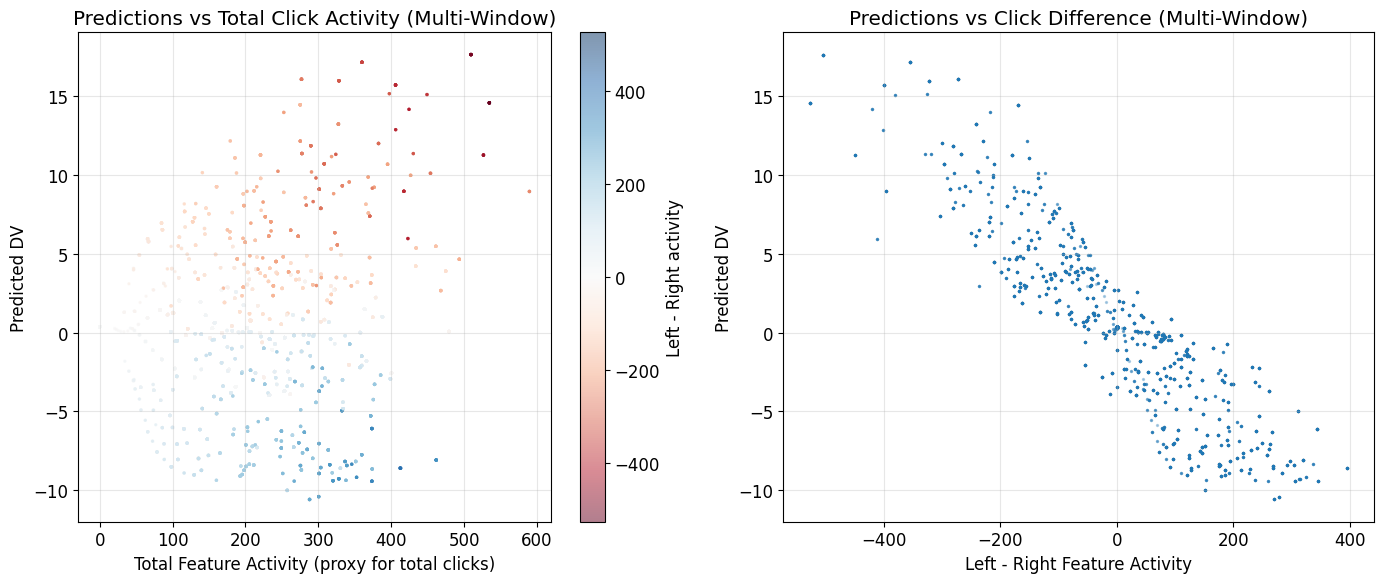

Unique total click values: 448
Unique click difference values: 448
Multi-window approach increases feature diversity (1x windows)
This helps reduce but doesn't eliminate discretization in outputs


In [ ]:
# Calculate total clicks per data point using corrected feature extraction
# Use helper to properly extract left and right features from all windows
left_features, right_features = helper.extract_features_by_side(X_valid)

left_click_sums = left_features.sum(axis=1)  # Sum of all left features across windows
right_click_sums = right_features.sum(axis=1)  # Sum of all right features across windows
total_clicks = left_click_sums + right_click_sums
click_diff = left_click_sums - right_click_sums

# Get predictions for valid data
y_pred_valid = model.predict(X_valid)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Predictions vs total clicks
scatter1 = ax1.scatter(total_clicks, y_pred_valid, c=click_diff, cmap='RdBu', 
                       alpha=0.5, s=2, vmin=-max(abs(click_diff)), vmax=max(abs(click_diff)))
ax1.set_xlabel('Total Feature Activity (proxy for total clicks)')
ax1.set_ylabel('Predicted DV')
ax1.set_title('Predictions vs Total Click Activity (Multi-Window)')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Left - Right activity')

# Right panel: Predictions vs click difference
ax2.scatter(click_diff, y_pred_valid, alpha=0.3, s=2)
ax2.set_xlabel('Left - Right Feature Activity')
ax2.set_ylabel('Predicted DV')
ax2.set_title('Predictions vs Click Difference (Multi-Window)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for discrete patterns
unique_totals = len(np.unique(np.round(total_clicks, 3)))
unique_diffs = len(np.unique(np.round(click_diff, 3)))
print(f"Unique total click values: {unique_totals}")
print(f"Unique click difference values: {unique_diffs}")
print(f"Multi-window approach increases feature diversity ({helper.n_windows}x windows)")
print(f"This helps reduce but doesn't eliminate discretization in outputs")